In [156]:
import pyarrow.parquet as pq
import numpy as np
import pickle
from pathlib import Path
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import matplotlib.pyplot as plt
from cfd_parquet import *
#folder = "C:/Users/karlen/Downloads/wcte_20241013_data"
folder = "/Users/jakobrimmer/Documents/TRIUMF/WCTE/analysis/time_cal/wcte_test/mPMT_led_events/18_11_2024"
plot_folder = "/Users/jakobrimmer/Documents/TRIUMF/WCTE/analysis/time_cal/wcte_test/plots"

runs=['20241118160504']
run = '20241118160504'



analysis = 'led'

expected_dts = [3125,25000,62500]


pf_wf = ParquetFile(folder+'/soft_single_'+run+'_waveforms.parquet') 
#pf_led = ParquetFile(folder+'/soft_single_'+run+'_led.parquet') 

tot_rows_wf = pf_wf.metadata.num_rows
#tot_rows_led = pf_led.metadata.num_rows

#tot_rows_wf = 2000000

#led = next(pf_led.iter_batches(batch_size = tot_rows_led)) 
wf = next(pf_wf.iter_batches(batch_size = tot_rows_wf))
          

df_wf = pa.Table.from_batches([wf]).to_pandas() 


card_id = df_wf.loc[:,'card_id']
chan = df_wf.loc[:,'chan']
samples = df_wf.loc[:,'samples']
coarse = df_wf.loc[:,'coarse']



In [3]:
# Here's how we can iterate through the entire file in chunks
import pyarrow.parquet as pq
import numpy as np
import pickle
from pathlib import Path
from pyarrow.parquet import ParquetFile
import pyarrow as pa 
import matplotlib.pyplot as plt
from cfd_parquet import *

folder = "/Users/jakobrimmer/Documents/TRIUMF/WCTE/analysis/time_cal/wcte_test/mPMT_led_events/18_11_2024"
plot_folder = "/Users/jakobrimmer/Documents/TRIUMF/WCTE/analysis/time_cal/wcte_test/plots"

runs=['20241118160504']
run = '20241118160504'



chunk_size = 10000
pf_wf = ParquetFile(folder+'/soft_single_'+run+'_waveforms.parquet') 

for batch in pf_wf.iter_batches(batch_size=chunk_size):
    # Process the chunk (batch)
   
    df_wf = pa.Table.from_batches([batch]).to_pandas(split_blocks=True, self_destruct=True)
    card_id = df_wf.loc[:,'card_id']
    

We want to first sort the data by brb and channel. Get the indices in the waveform data for each brb and each channel in the brb...

In [157]:
indices = {}
brb_indices = {}
brbs_unique = np.unique(card_id)
chans_unique = np.unique(chan)
#Cycle through card ids and channels, add them to the indices dictionary
for i in range(len(brbs_unique)):
    brb_curr_idx = np.where(card_id==brbs_unique[i])[0]
    indices[str(brbs_unique[i])] = {}
    
    for j in range(len(chans_unique)):
        chan_curr_idx = np.intersect1d(brb_curr_idx,np.where(chan==chans_unique[j])[0])
        indices[str(brbs_unique[i])][str(chans_unique[j])] = chan_curr_idx
    
    

Now we want to get the number of pulses per waveform for each channel, as well as the amplitude distributions

In [241]:
cfd_fits = {}
threshold=20
for mpmt in indices.keys():
    cfd_fits[str(mpmt)] = {}
    for channel in indices[str(mpmt)].keys():
        cfd_fits[str(mpmt)][str(channel)] = {'hits_per_wf':[],'t':[],'amp':[],'baseline':[]}
        
        # First get the peak timebins
        peak_timebins_all = []
        
        for sample in samples[indices[mpmt][channel]]:
            peak_timebins_all.append(get_peak_timebins(sample,threshold))
        
        # Get the total number of peaks that this PMT sees across all of its waveforms 
        total_peaks = sum([len(peak_timebins_all[i]) for i in range(len(peak_timebins_all))])
        # Now do the CFD fitting...
        
        # Get the average number of hits per waveform
        peak_frac = total_peaks/len(samples[indices[mpmt][channel]])
        
        cfd_fits[str(mpmt)][str(channel)]['hits_per_wf'].append(peak_frac)
        
        data_length=256
        
        i = 0
        for sample in samples[indices[mpmt][channel]]:
            for j in range(len(peak_timebins_all[i])):
                fit_start = peak_timebins_all[i][j] - 7
                ts = np.array([i for i in range(fit_start, peak_timebins_all[i][j] + 2)])
                adcs = np.array([sample[its] for its in ts])
                
                if peak_timebins_all[i][j] < data_length - 4:
        
                    ts_cfd = np.array([i for i in range(fit_start, peak_timebins_all[i][j] + 4)])
                    adcs_cfd = np.array([sample[its] for its in ts_cfd])
                    its_cfd = np.arange(0., len(adcs_cfd), 1.)
                    offset = min(50,max(0,np.argmax(samples[i]) - 6))
                    t0, amp, baseline = get_cfd(adcs_cfd)
         
                    if t0 >0 and amp>threshold:
                        cfd_fits[str(mpmt)][str(channel)]['t'].append(t0+fit_start)
                        cfd_fits[str(mpmt)][str(channel)]['amp'].append(amp)
                        cfd_fits[str(mpmt)][str(channel)]['baseline'].append(baseline)
                    
            i+=1

We now want to be able to plot all amplitude distributions if needed...

/var/folders/9n/g32ycb4j3pz04p5hdzhnxzvm0000gn/T/ipykernel_60322/2026069524.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(5, 4, figsize=(15, 12))


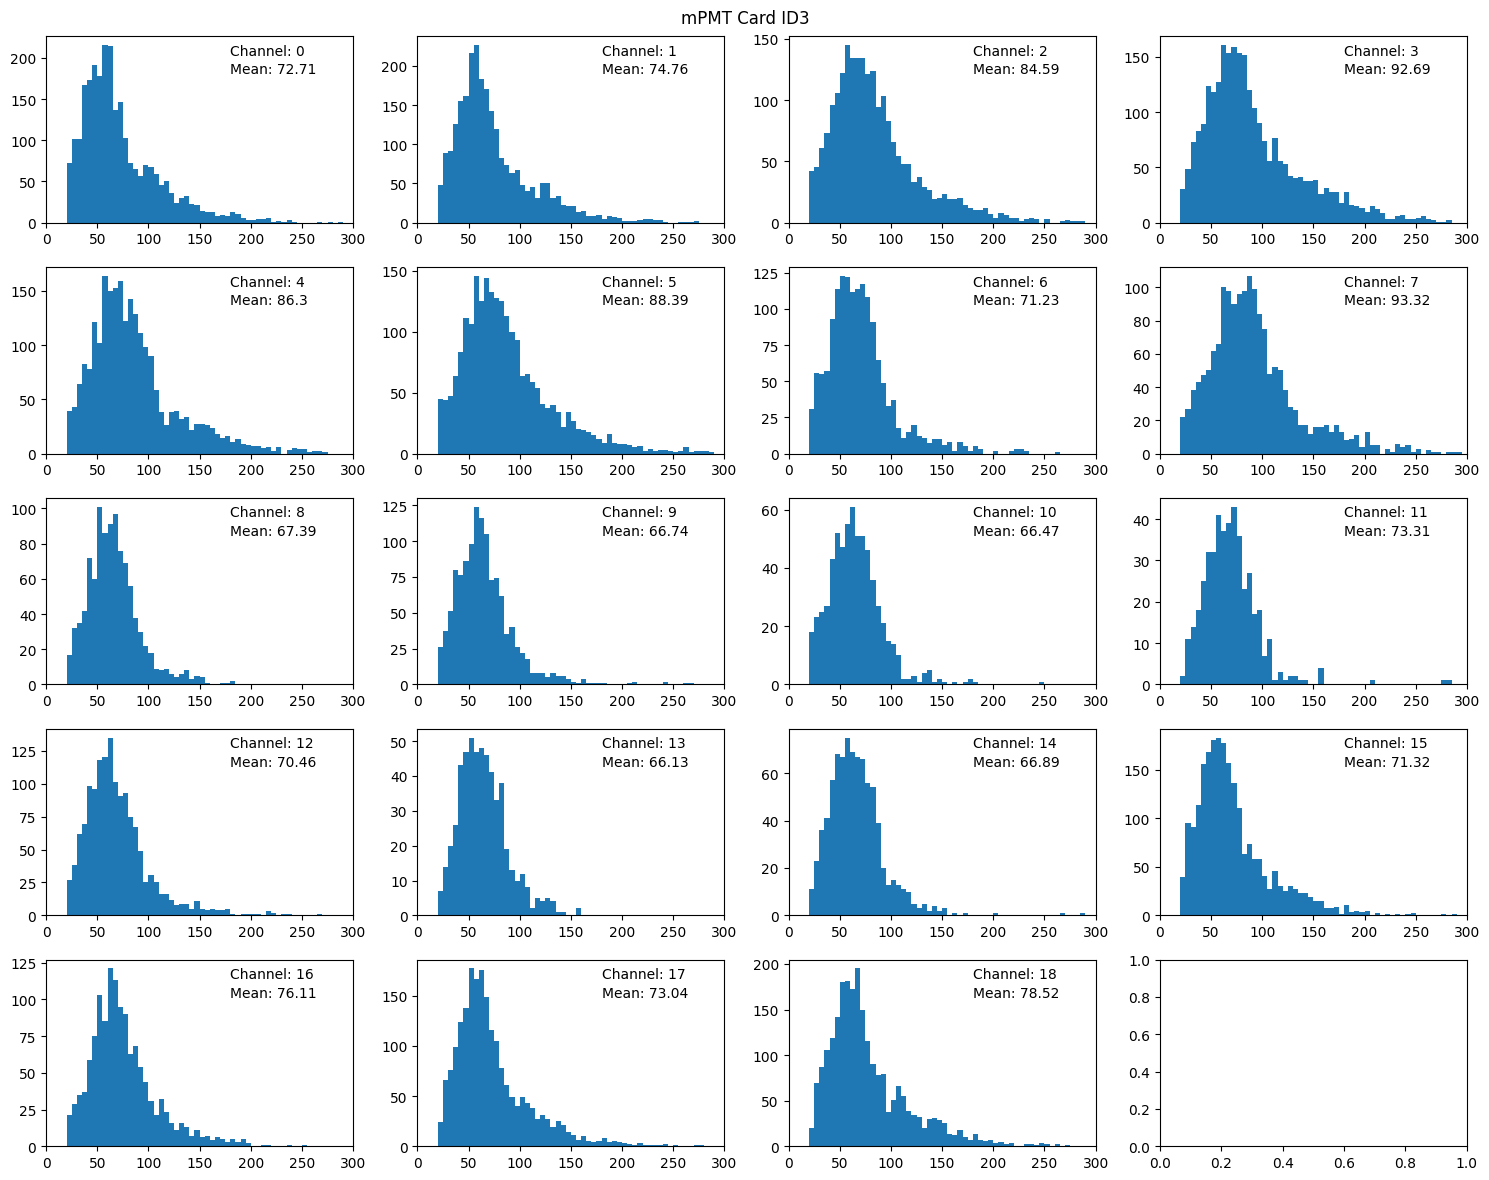

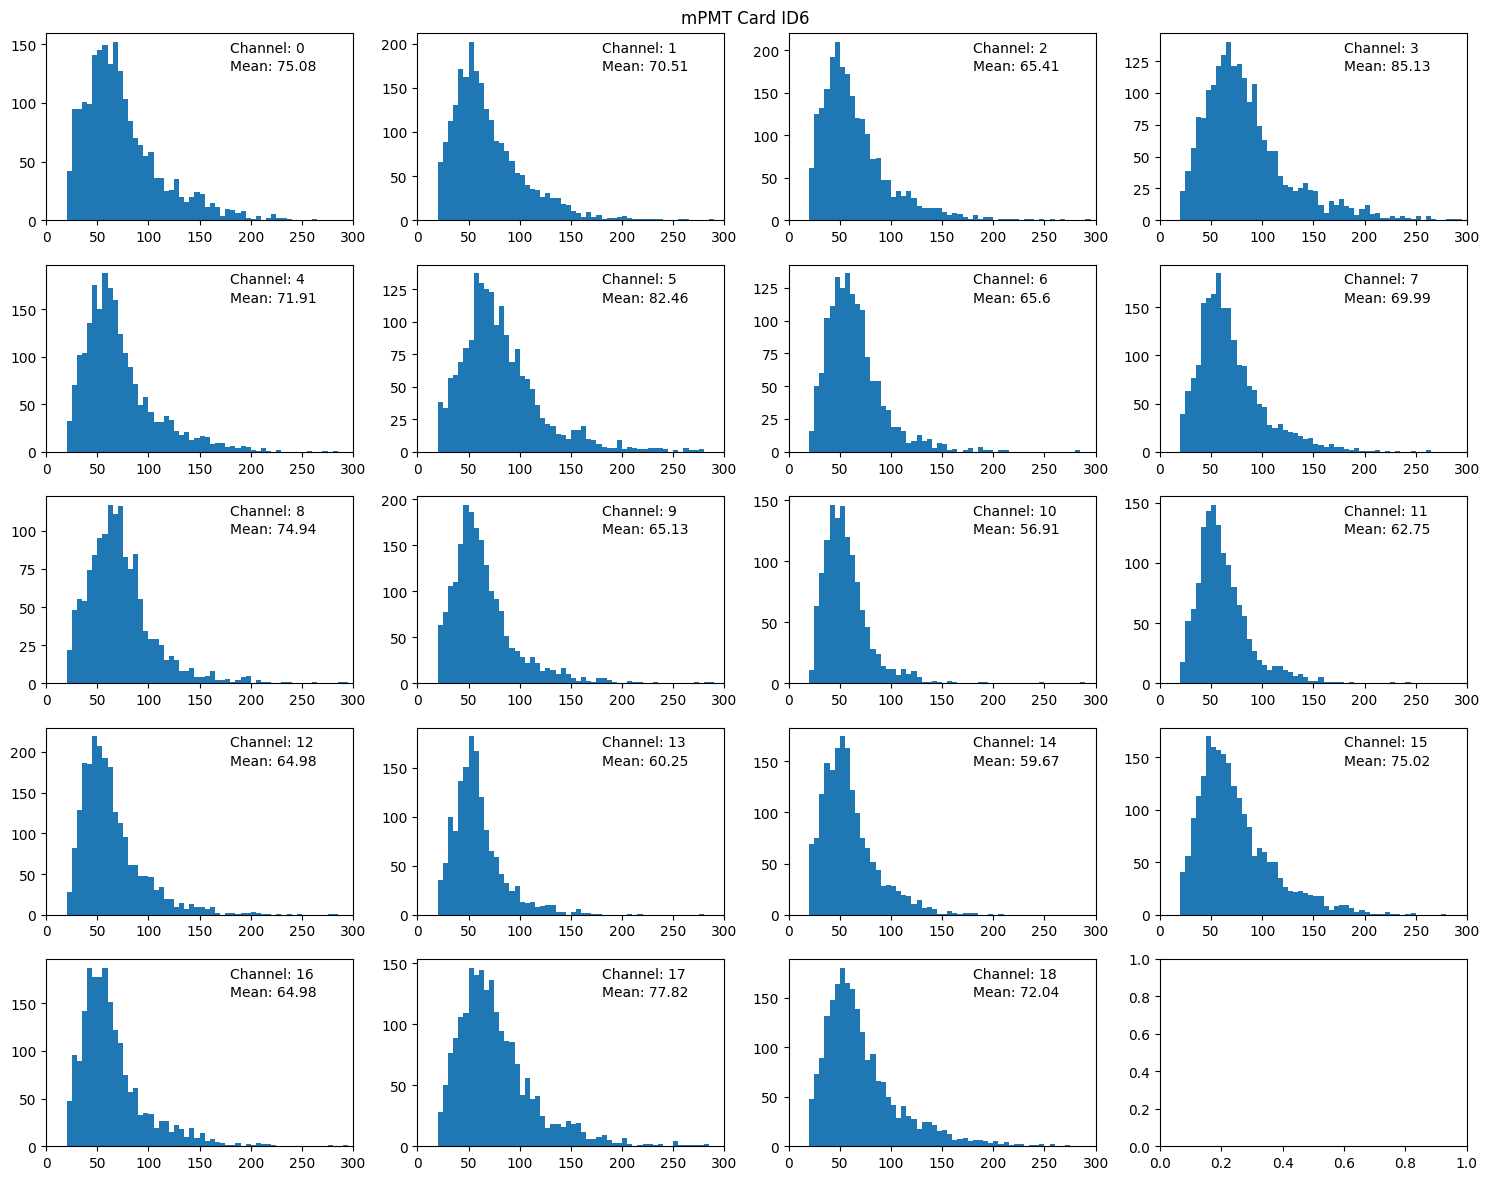

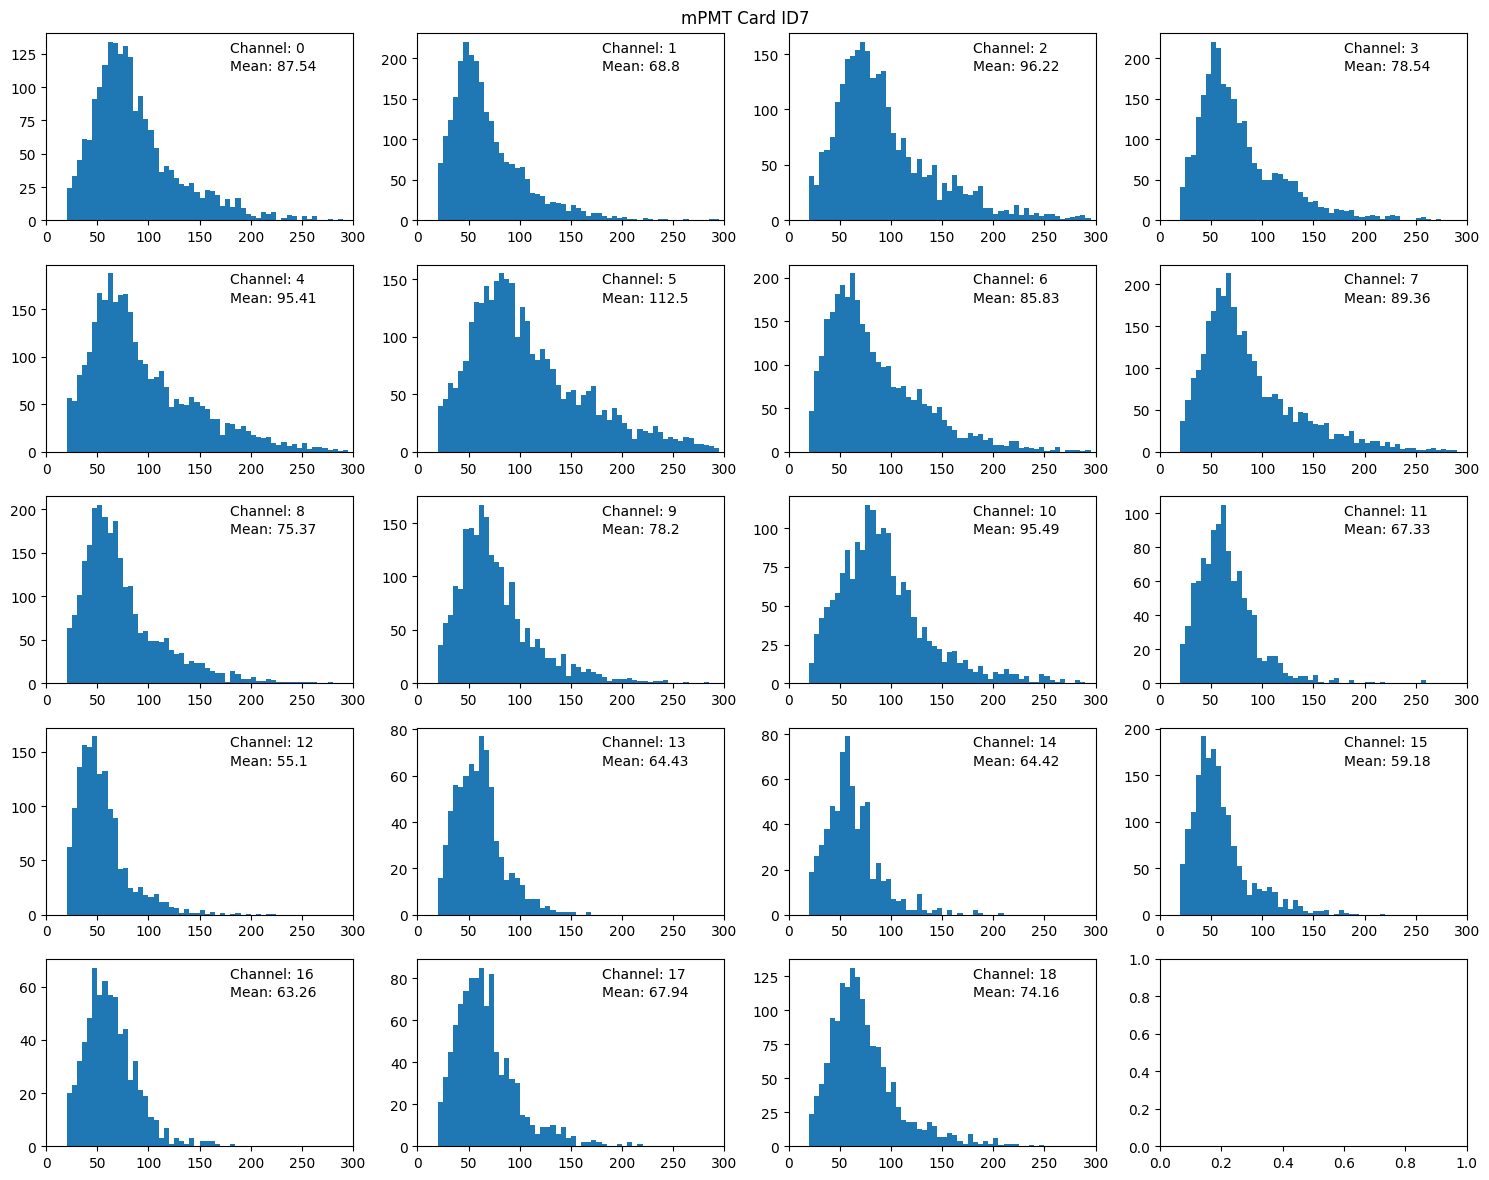

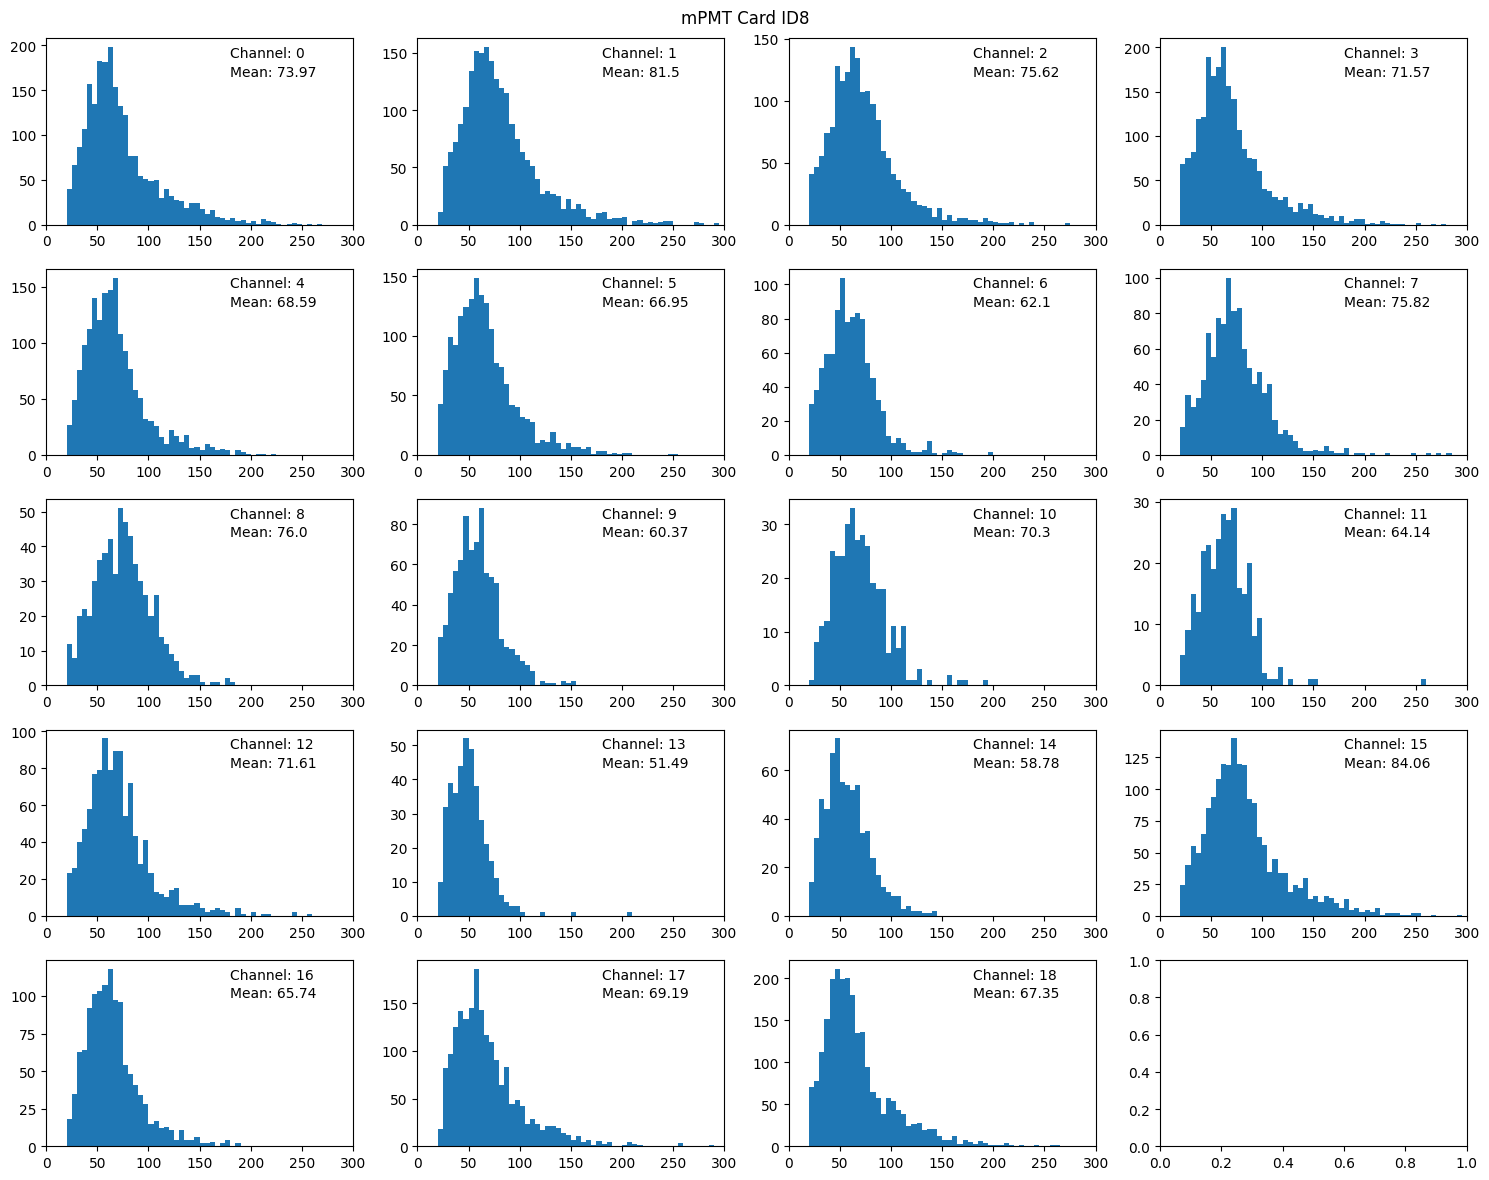

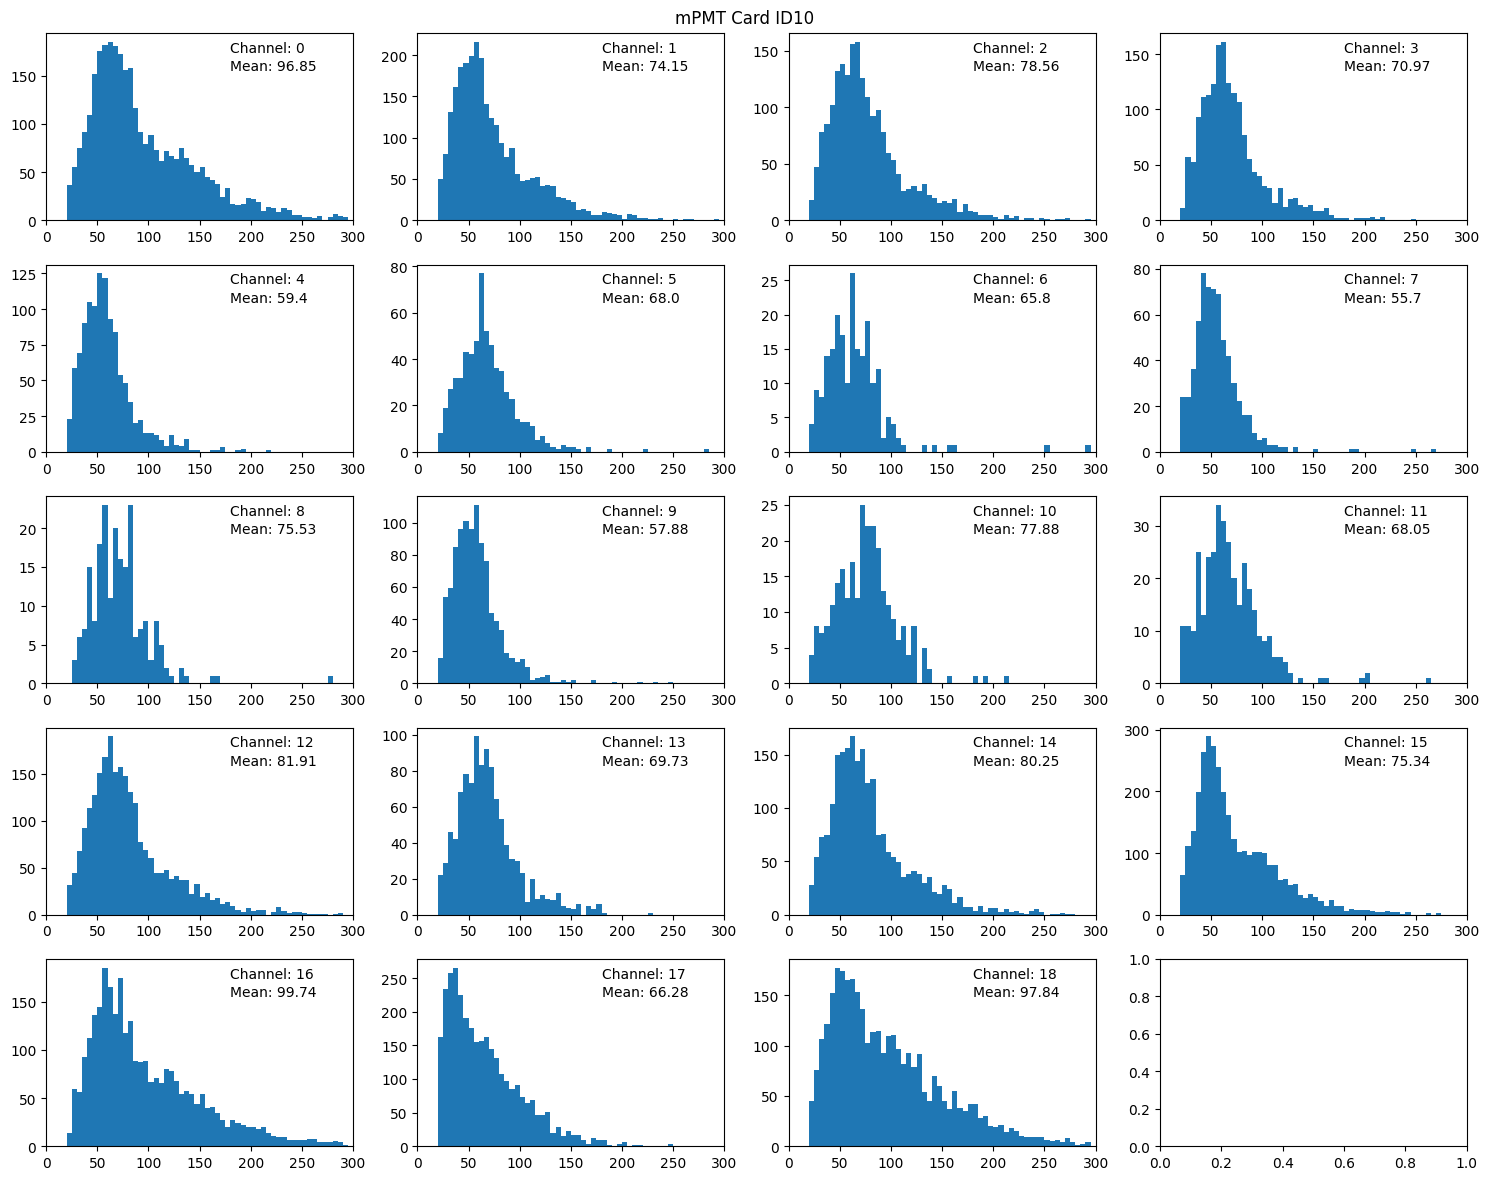

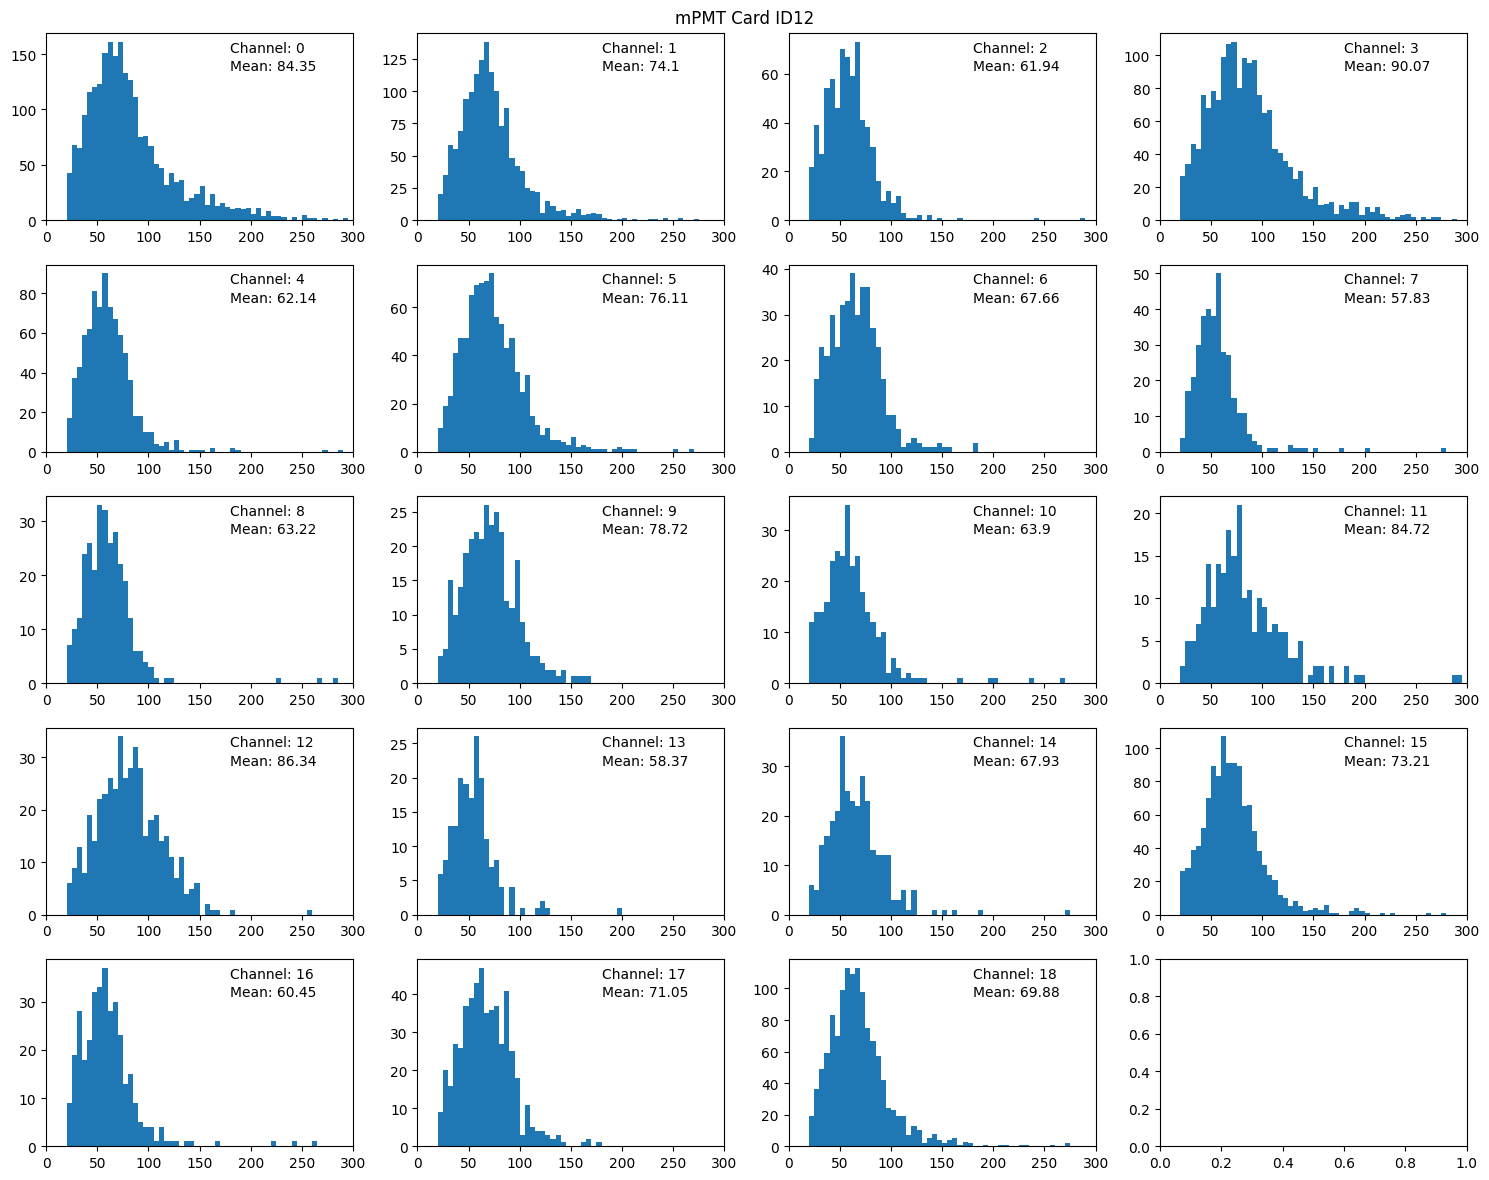

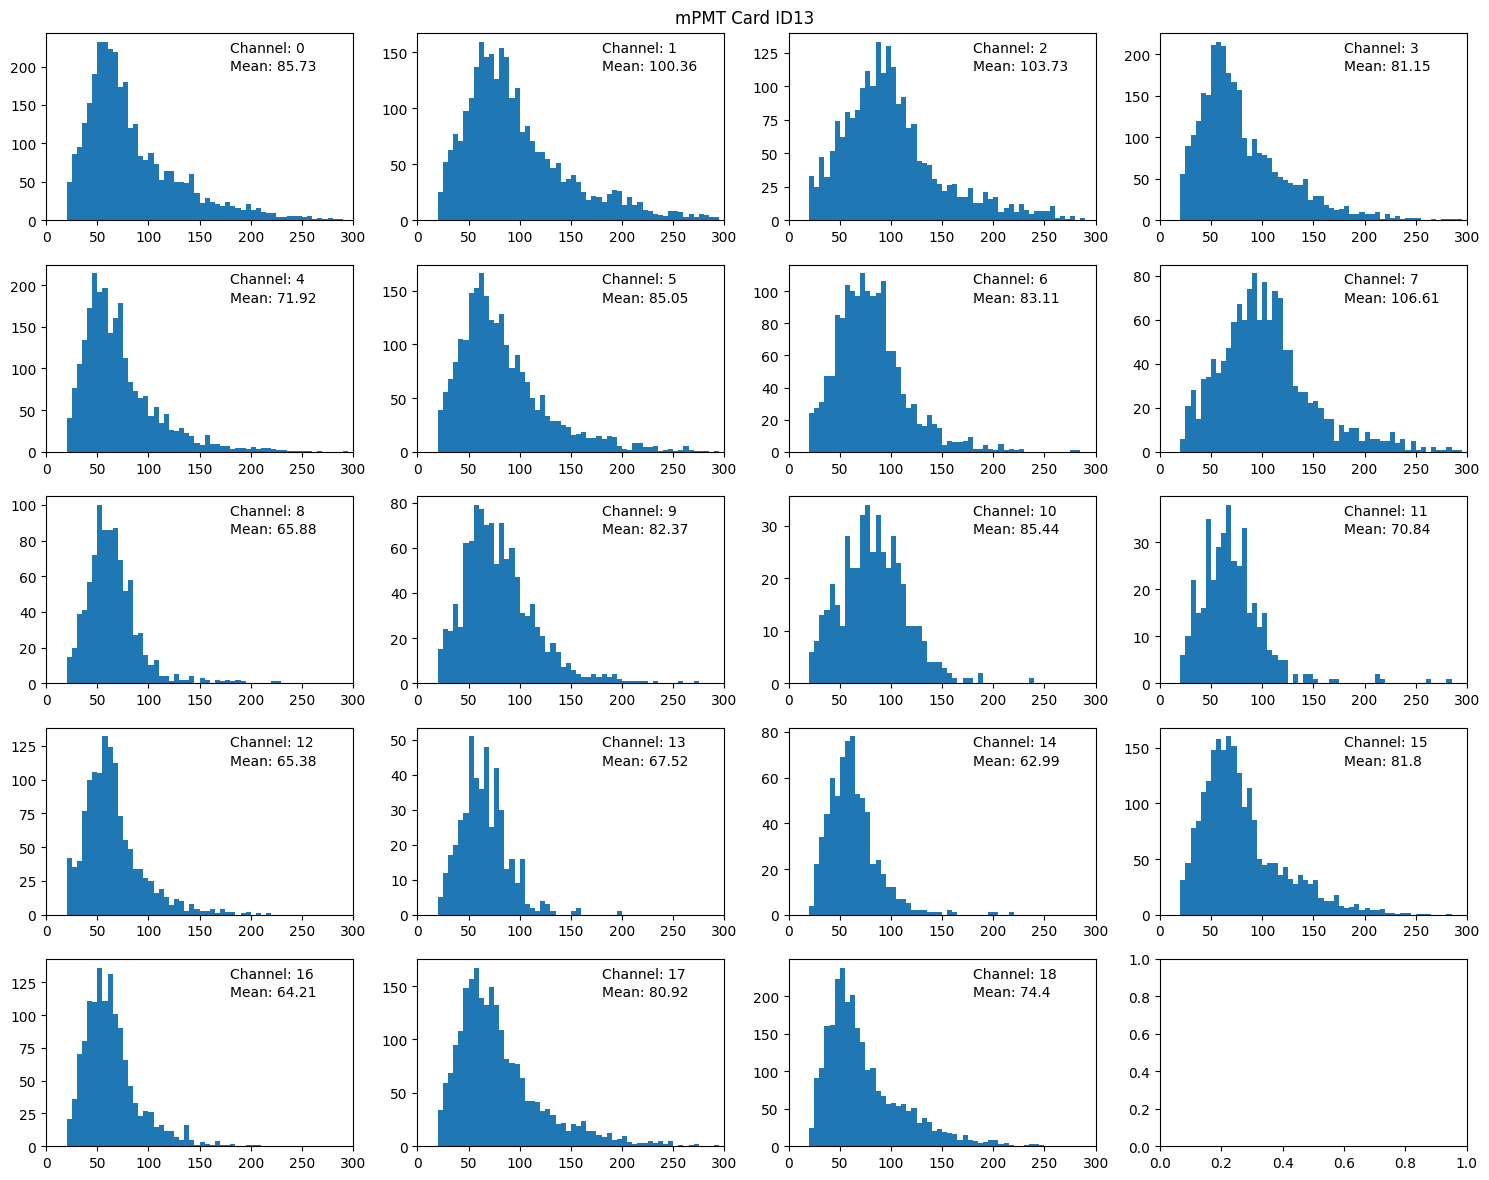

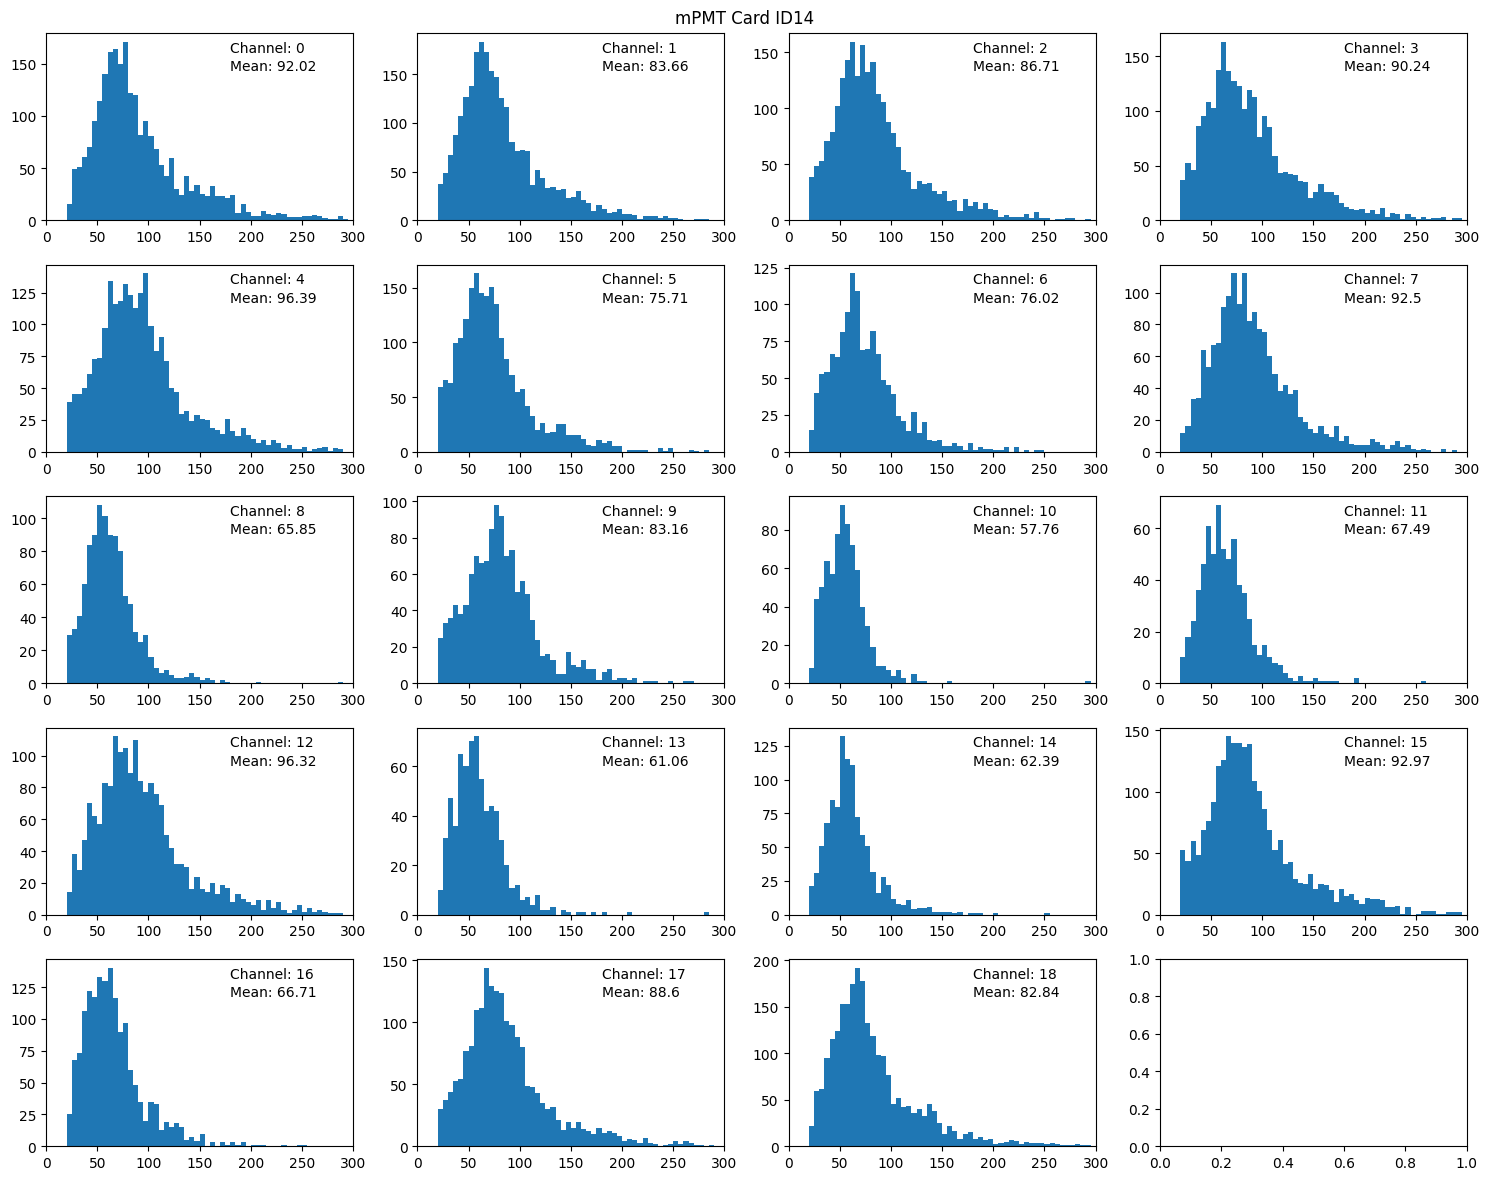

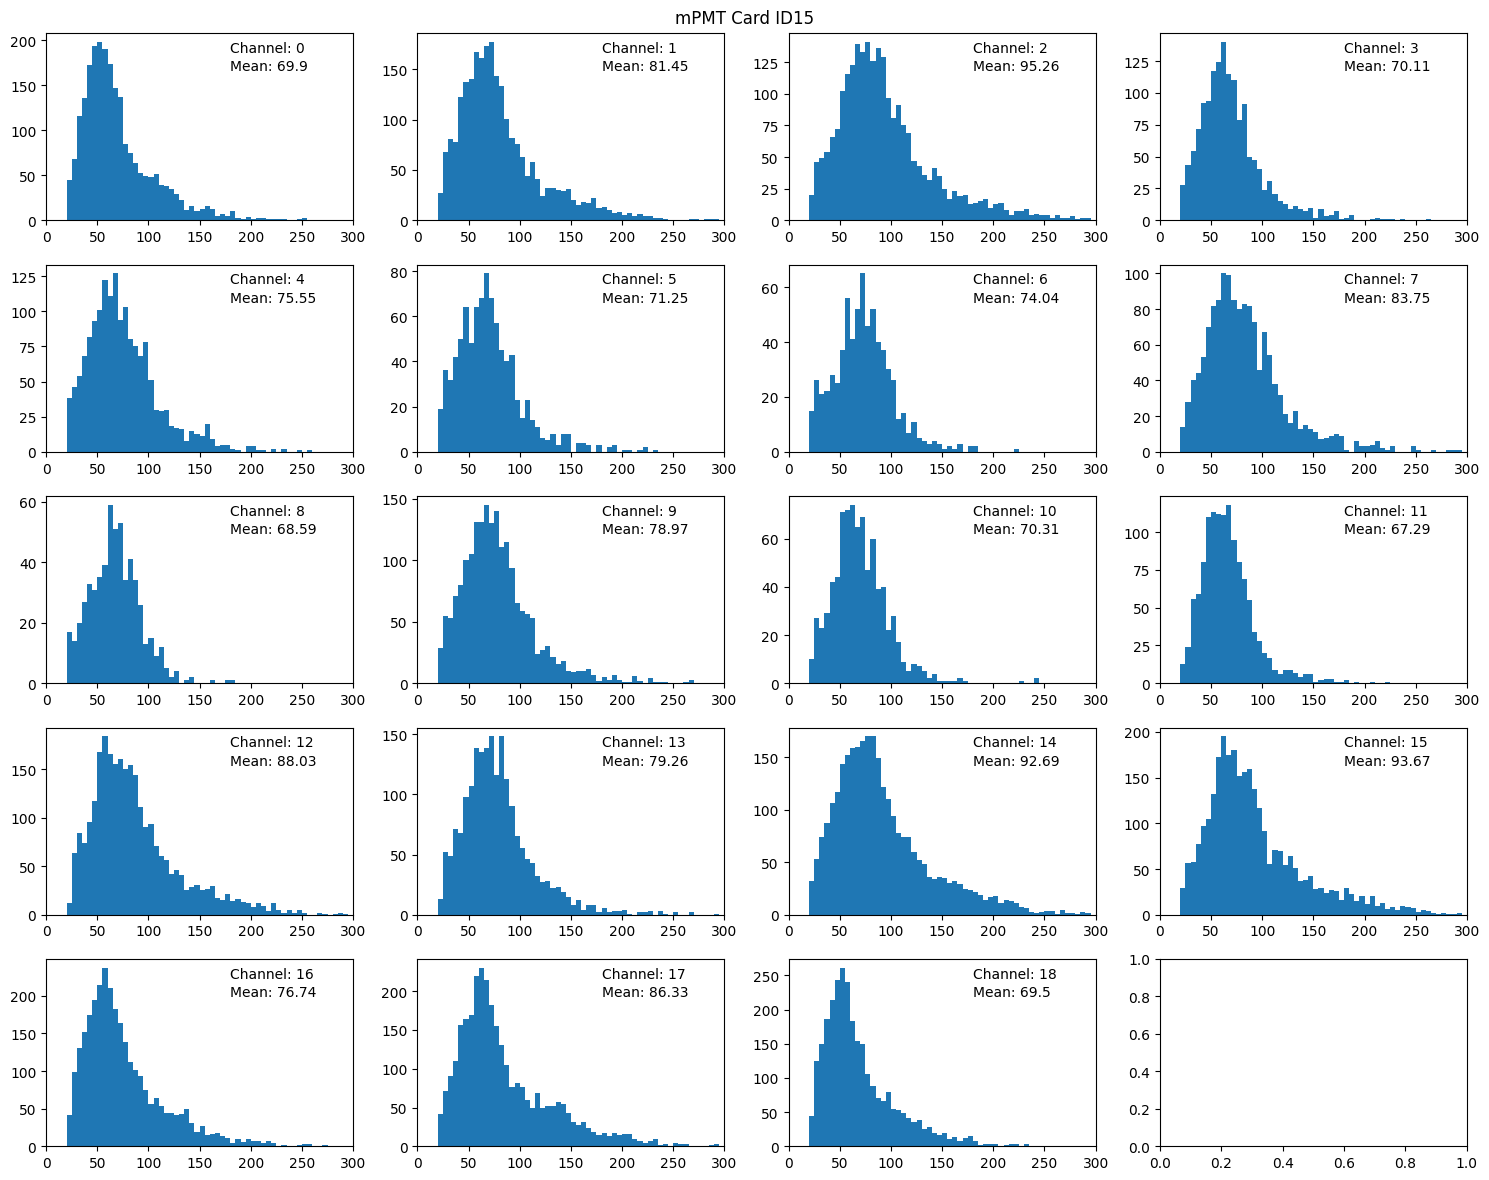

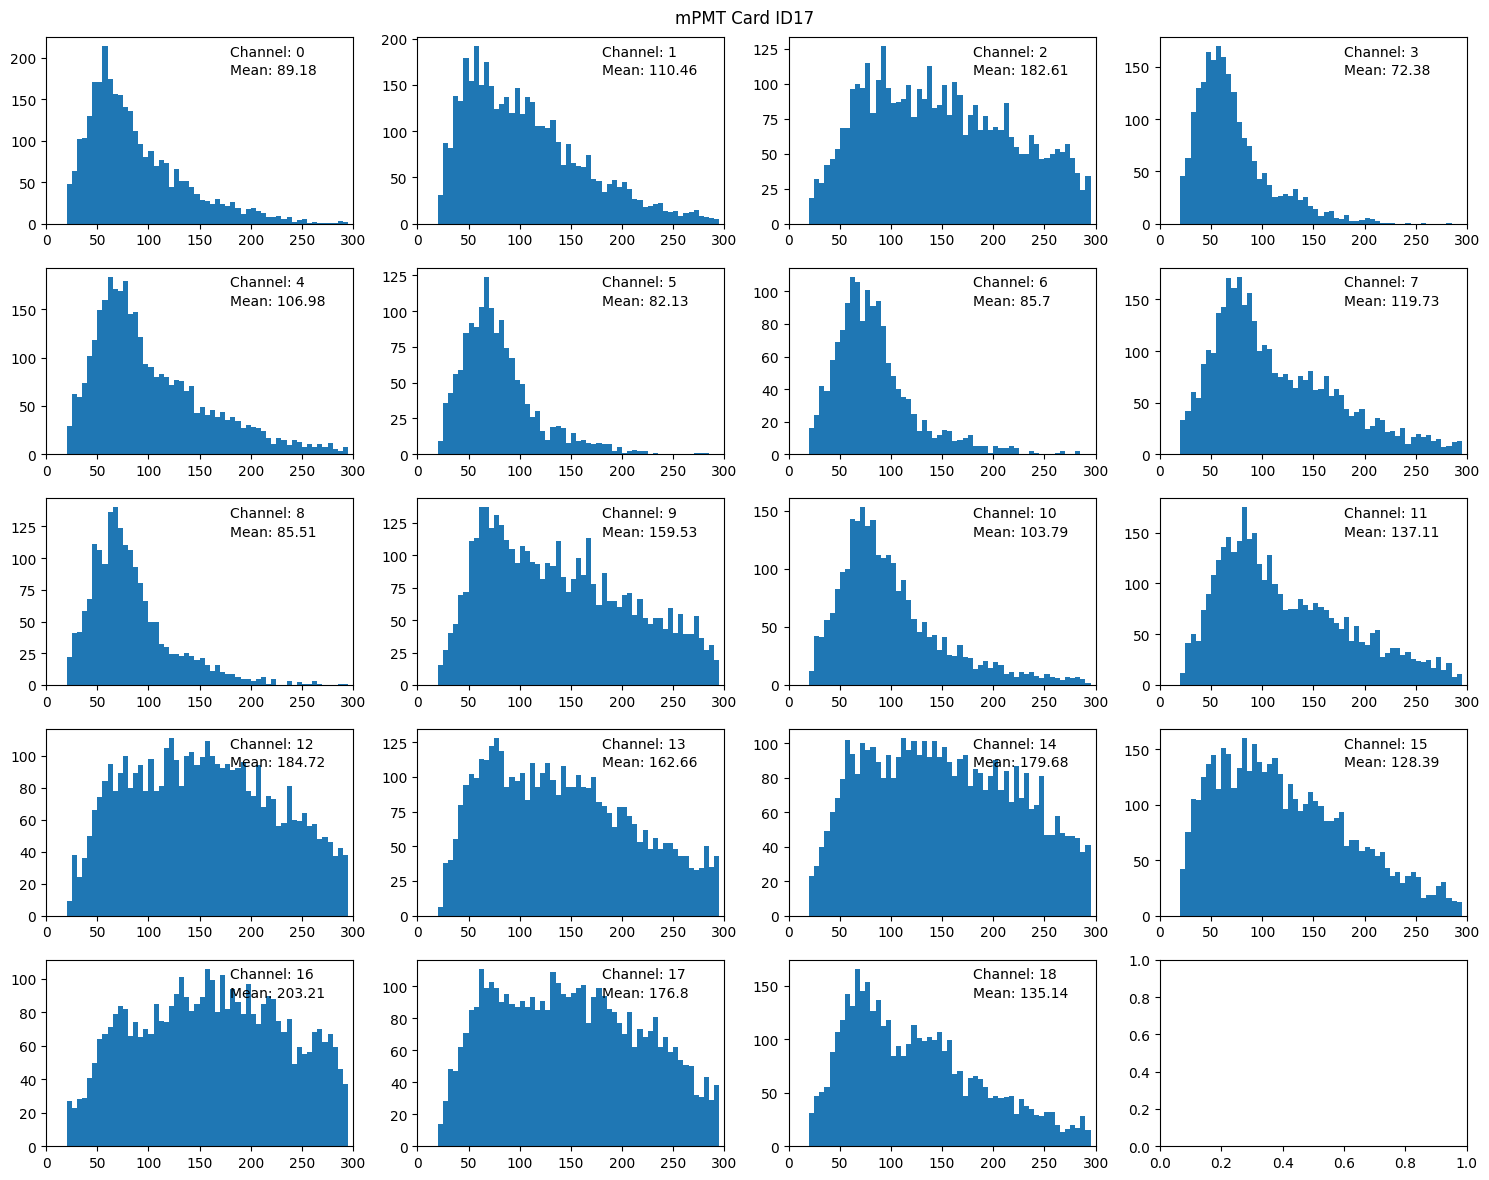

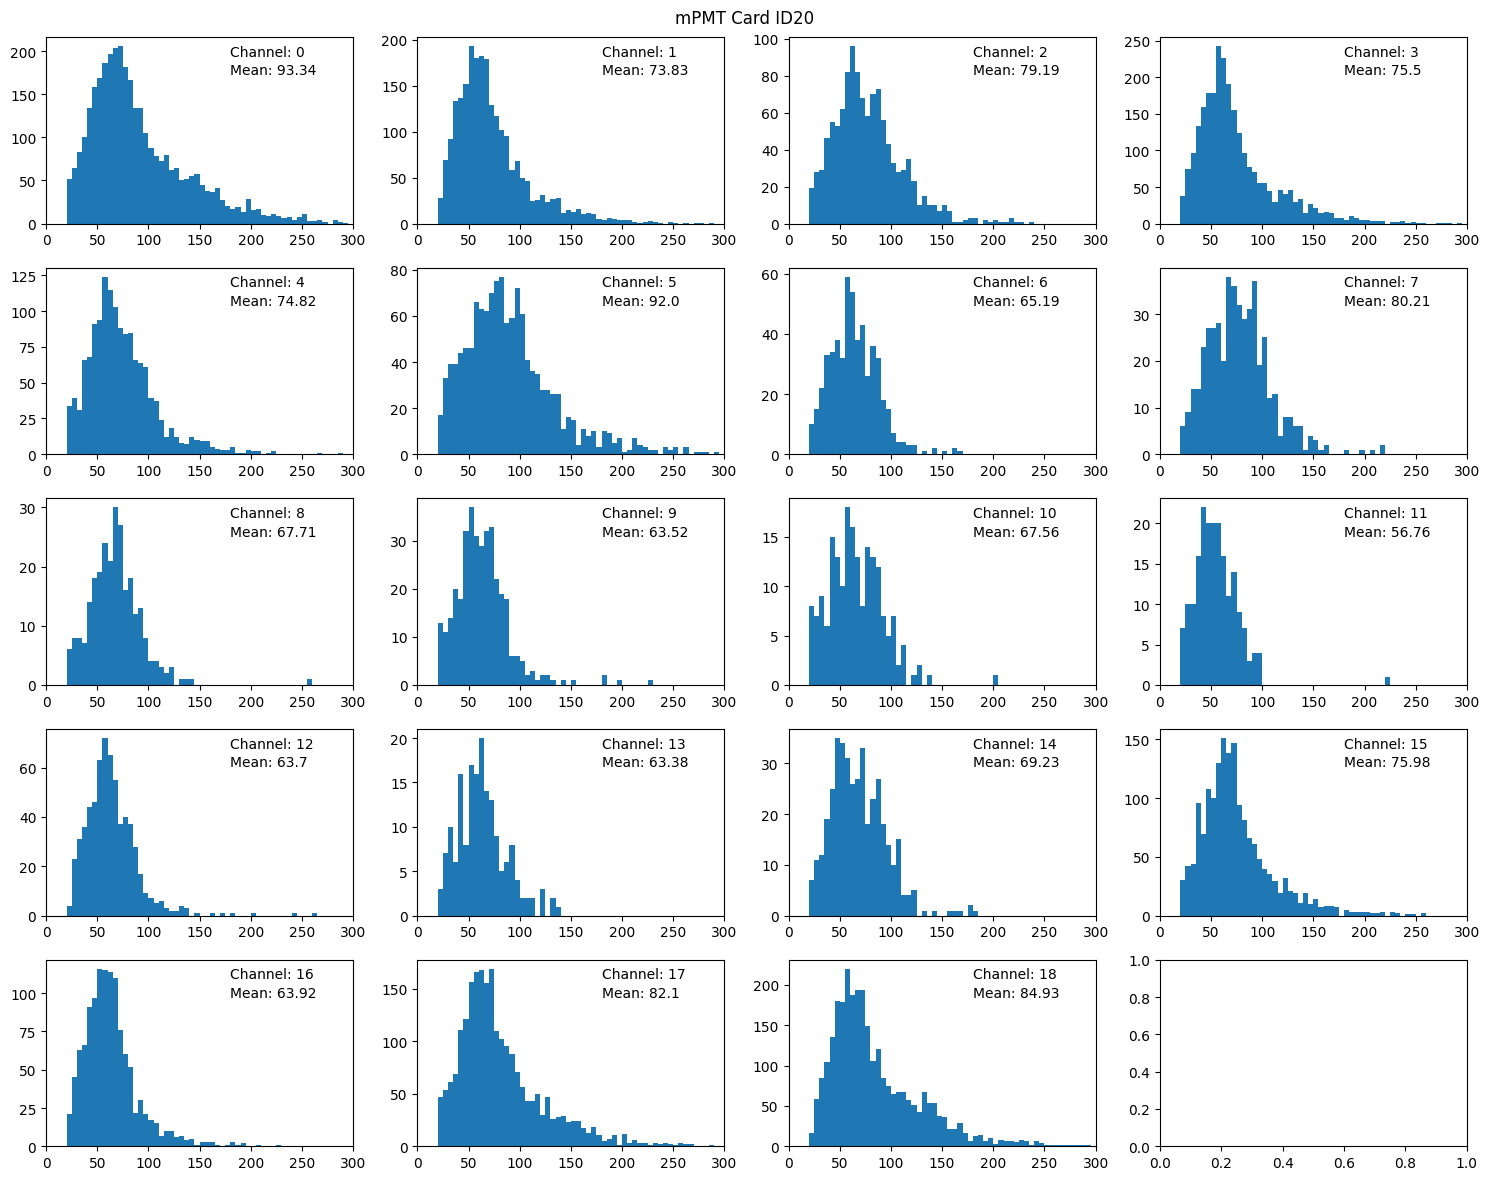

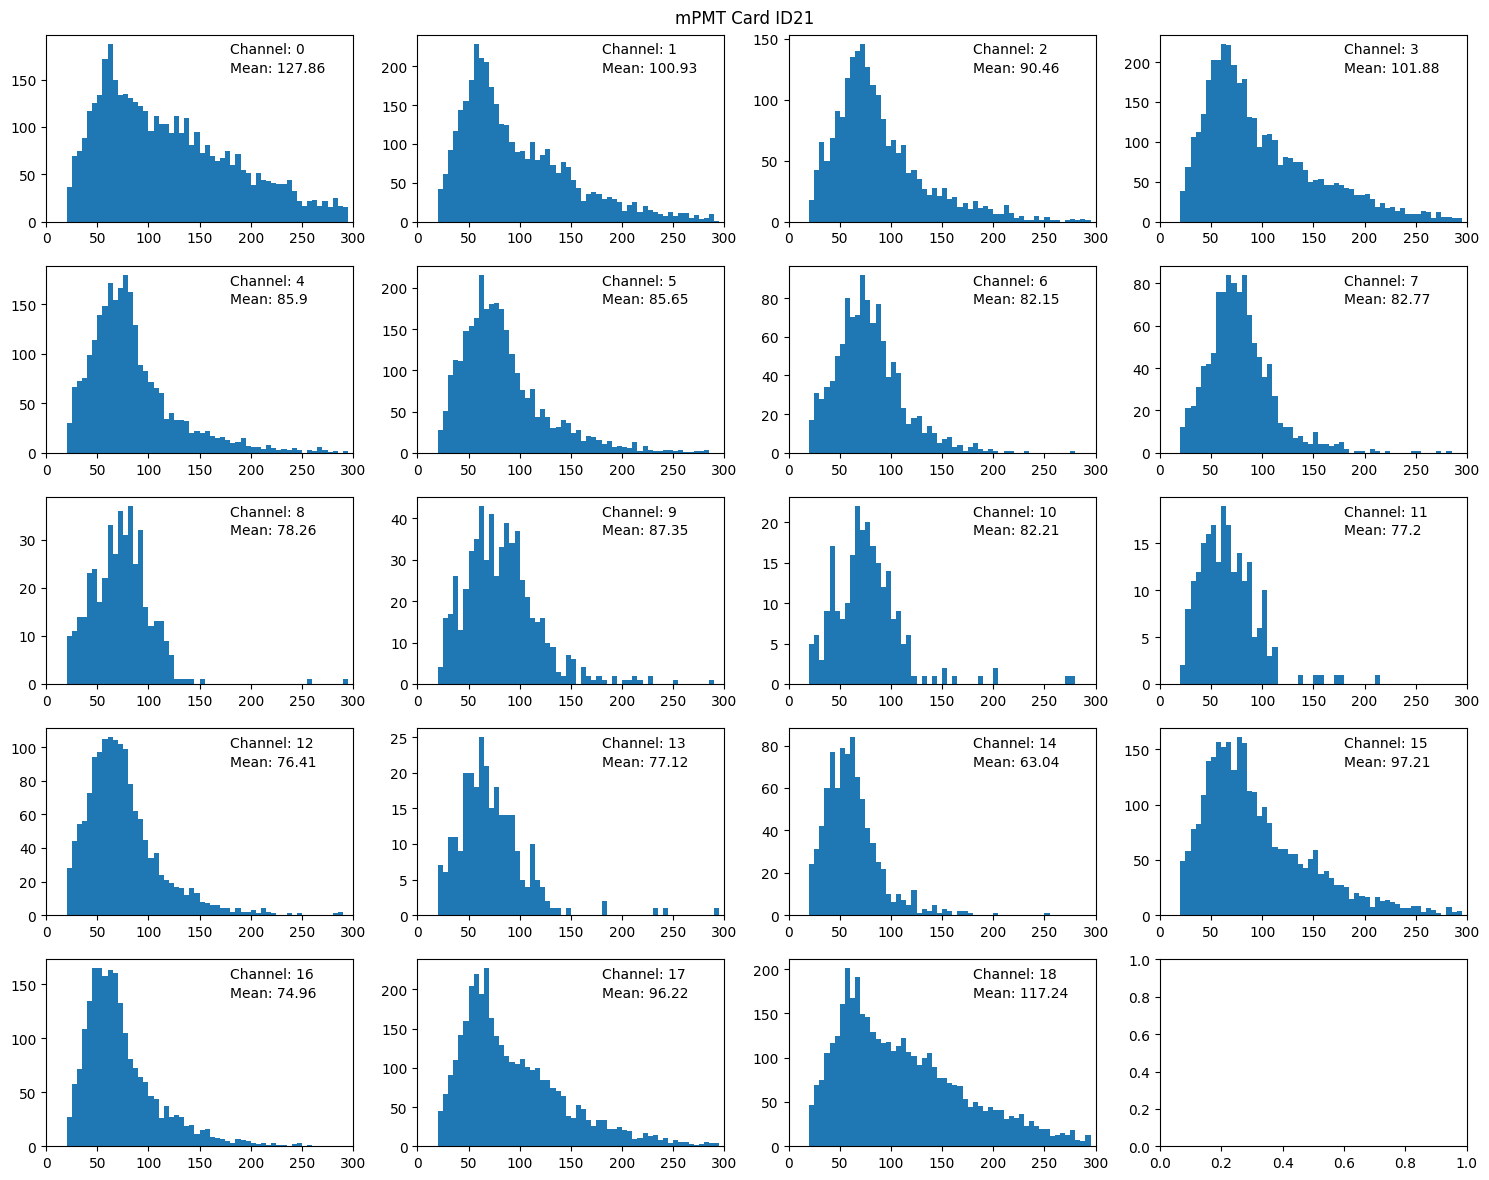

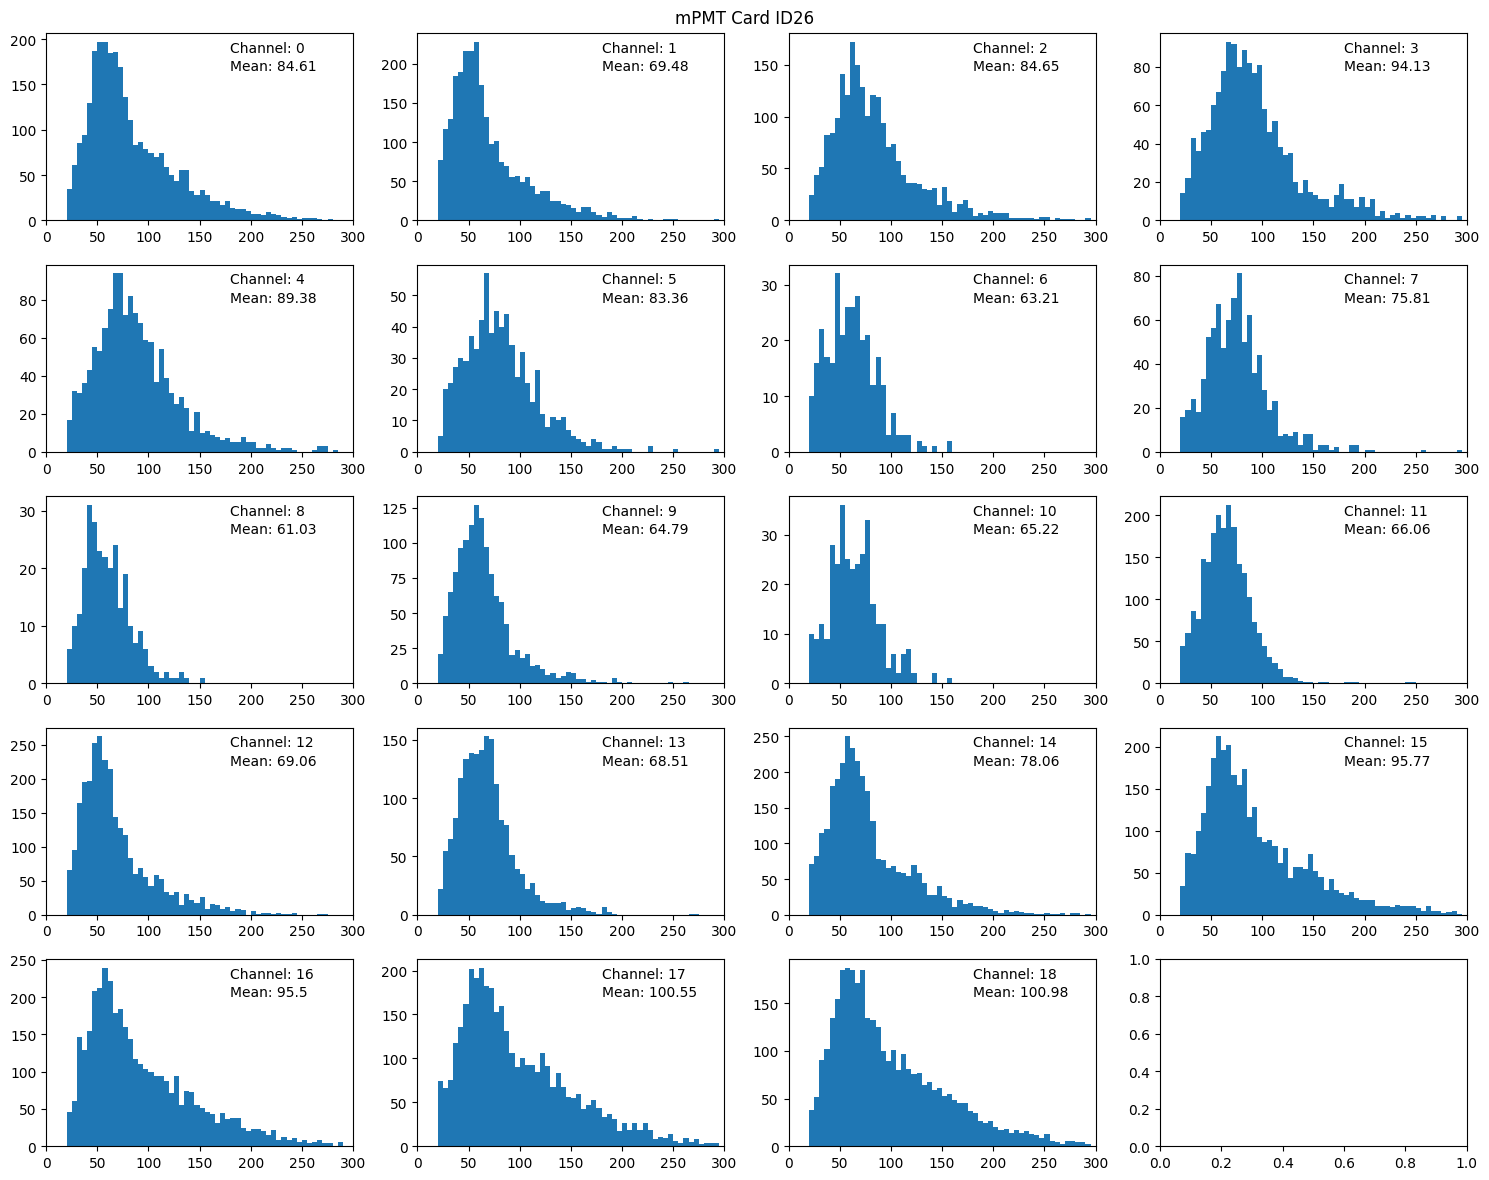

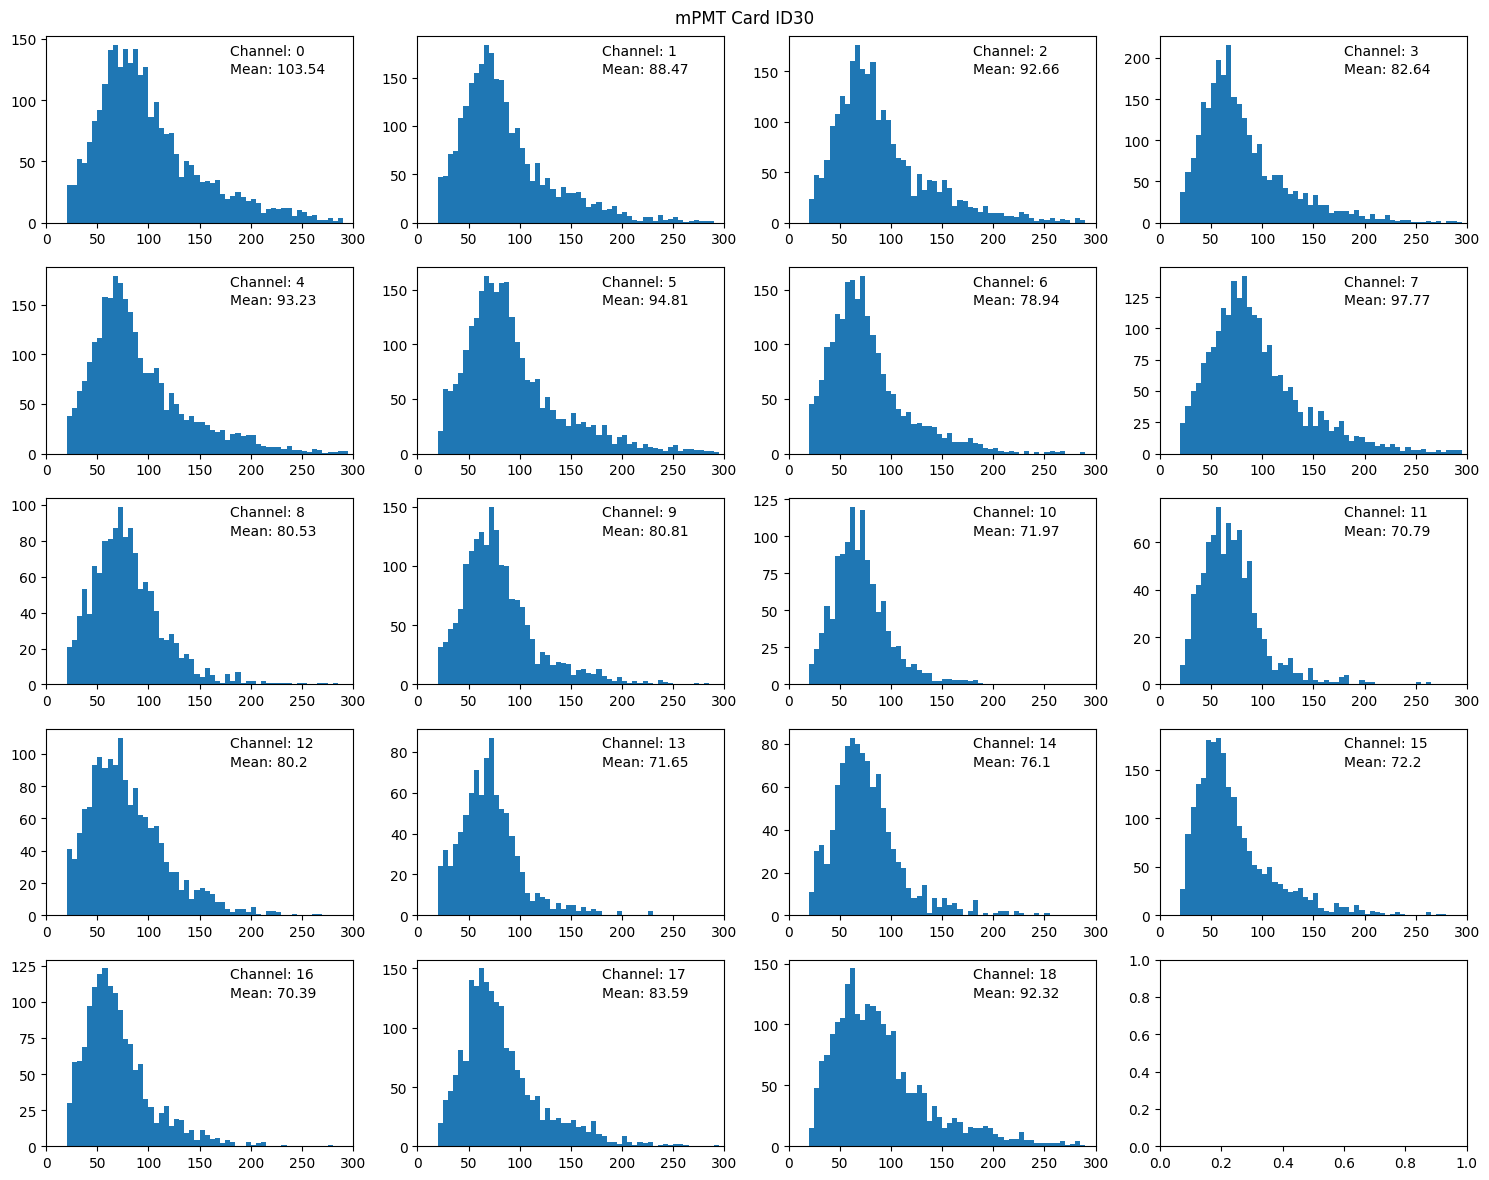

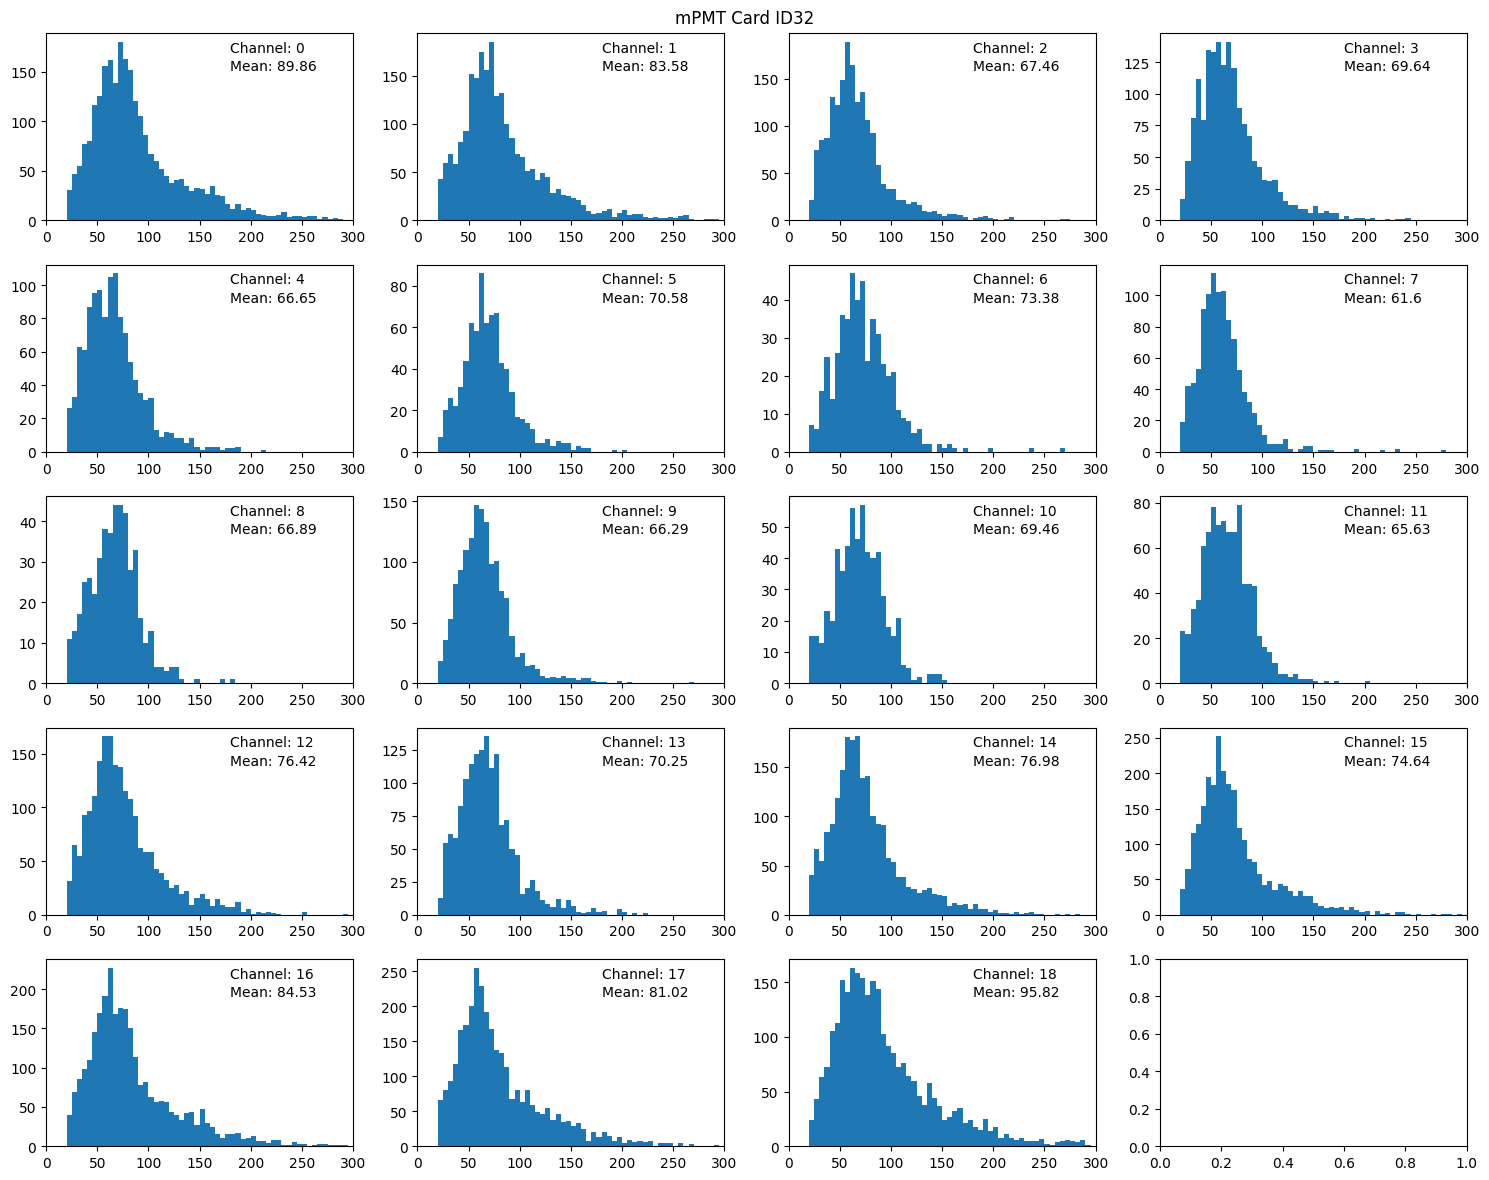

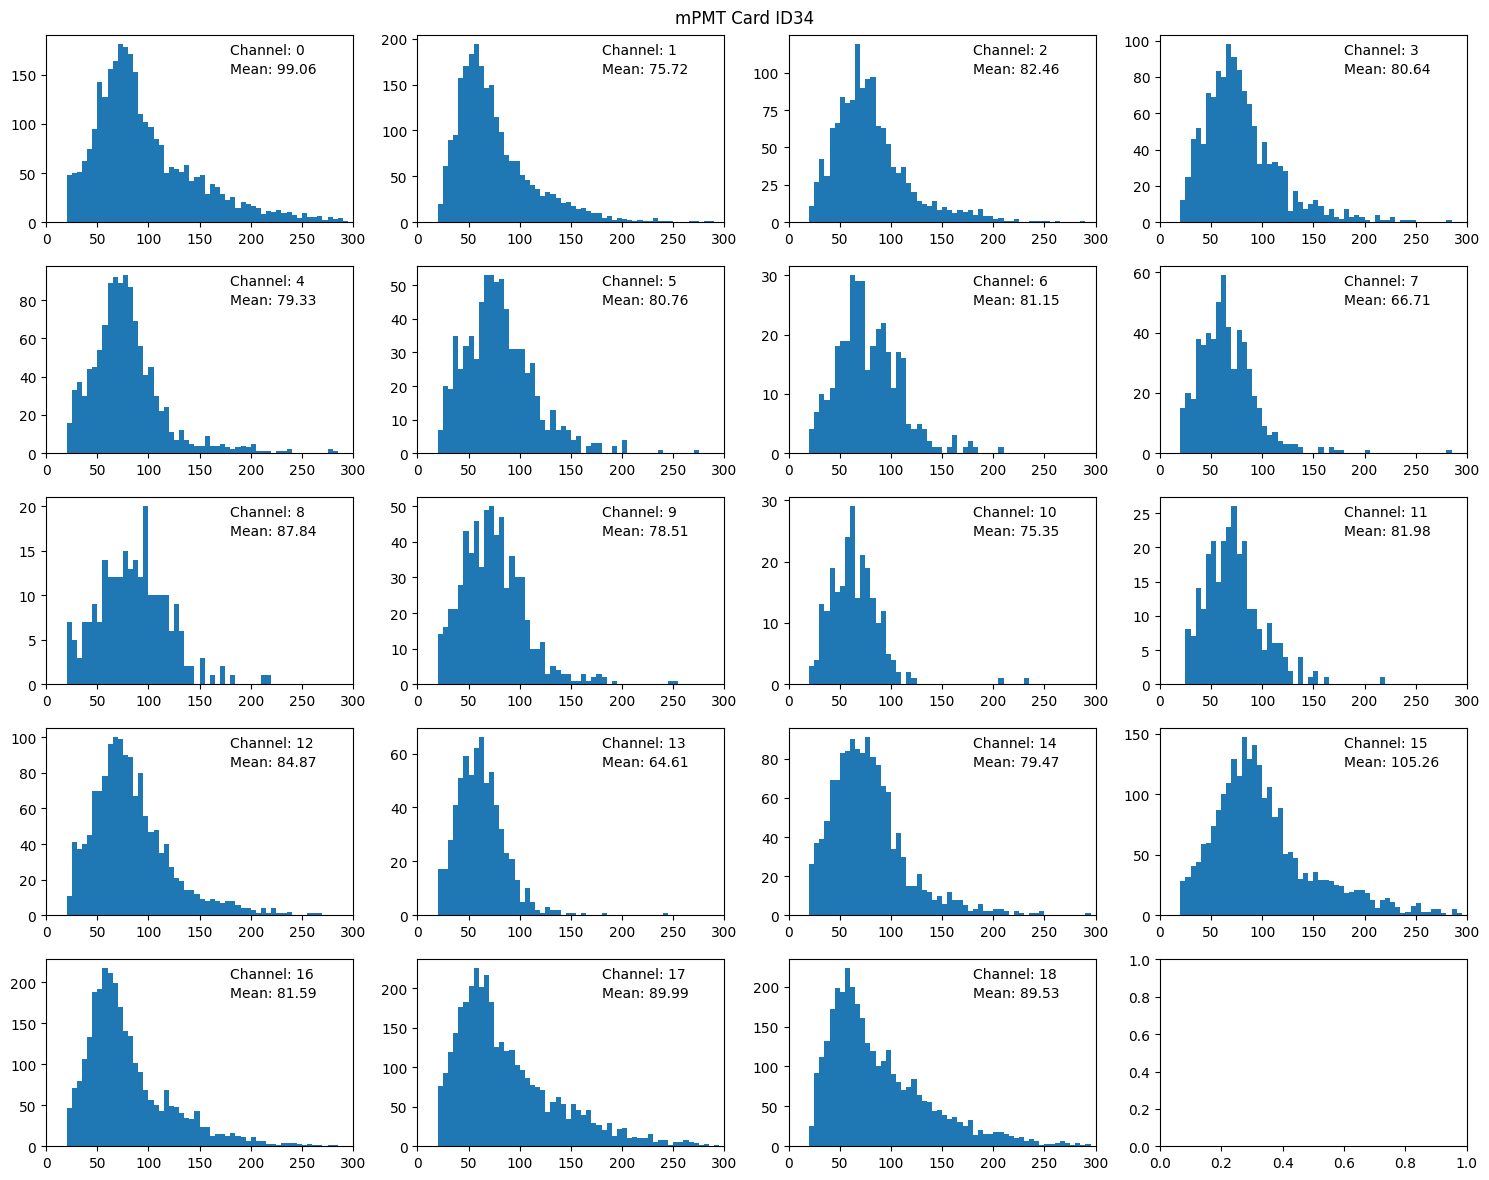

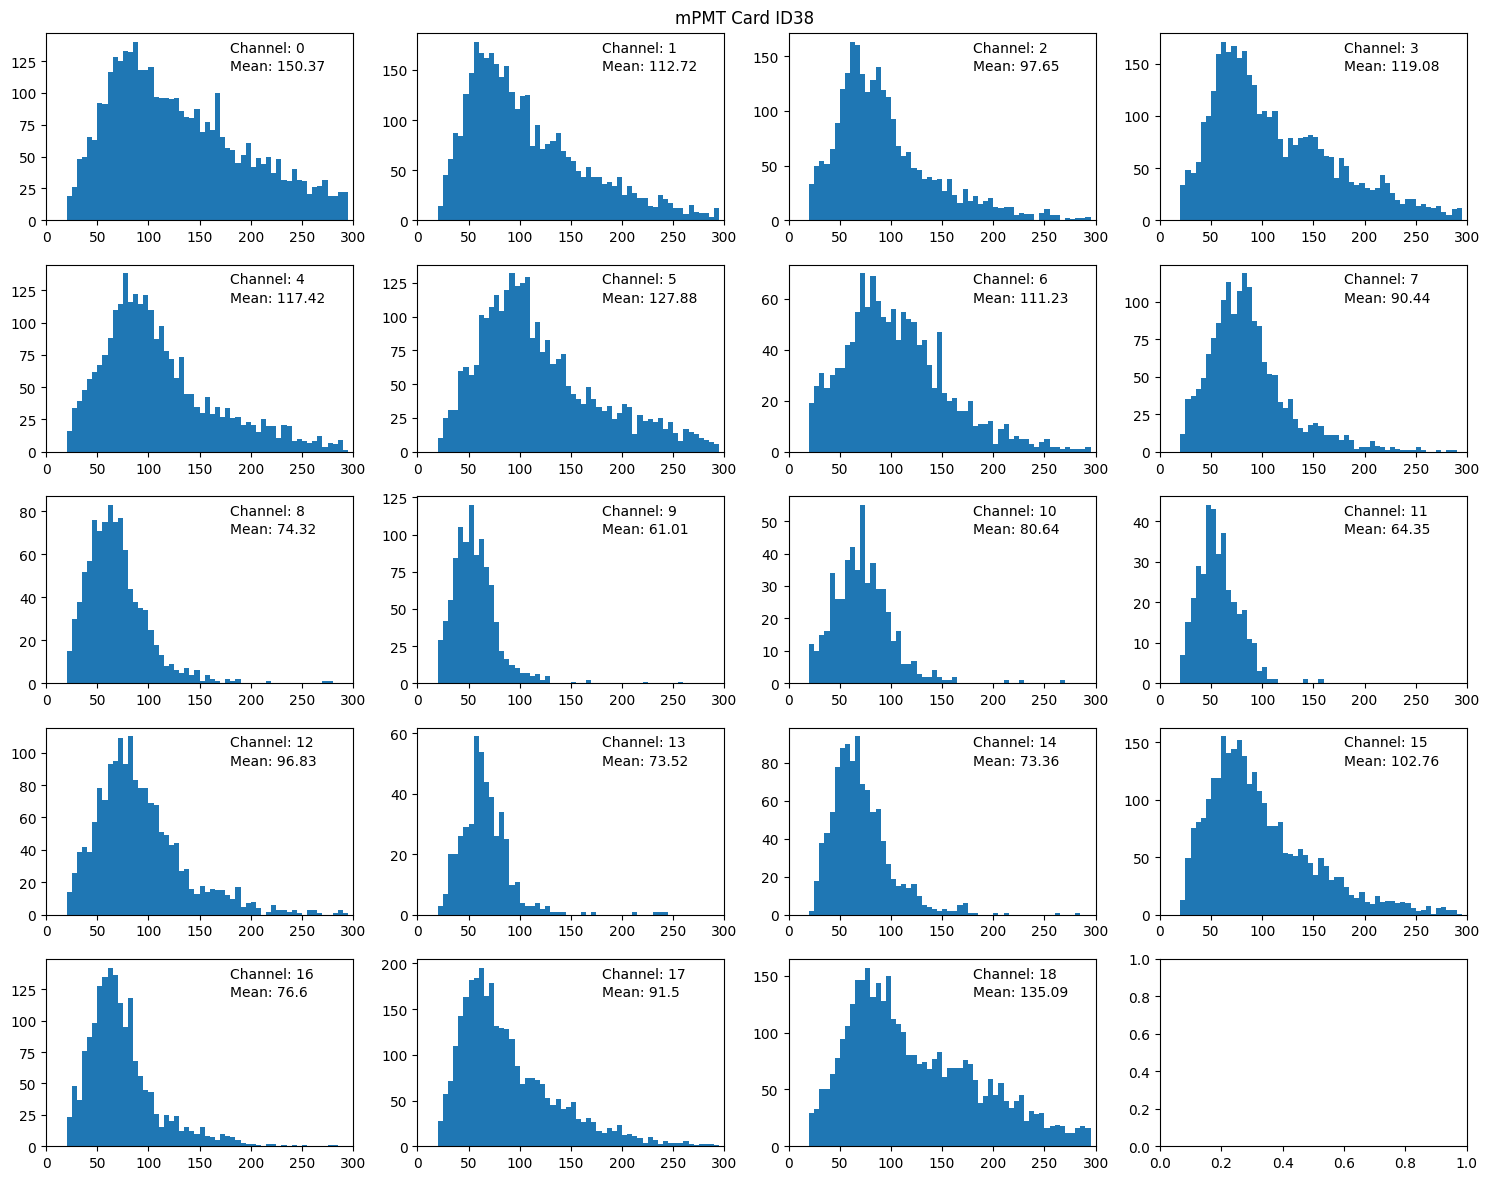

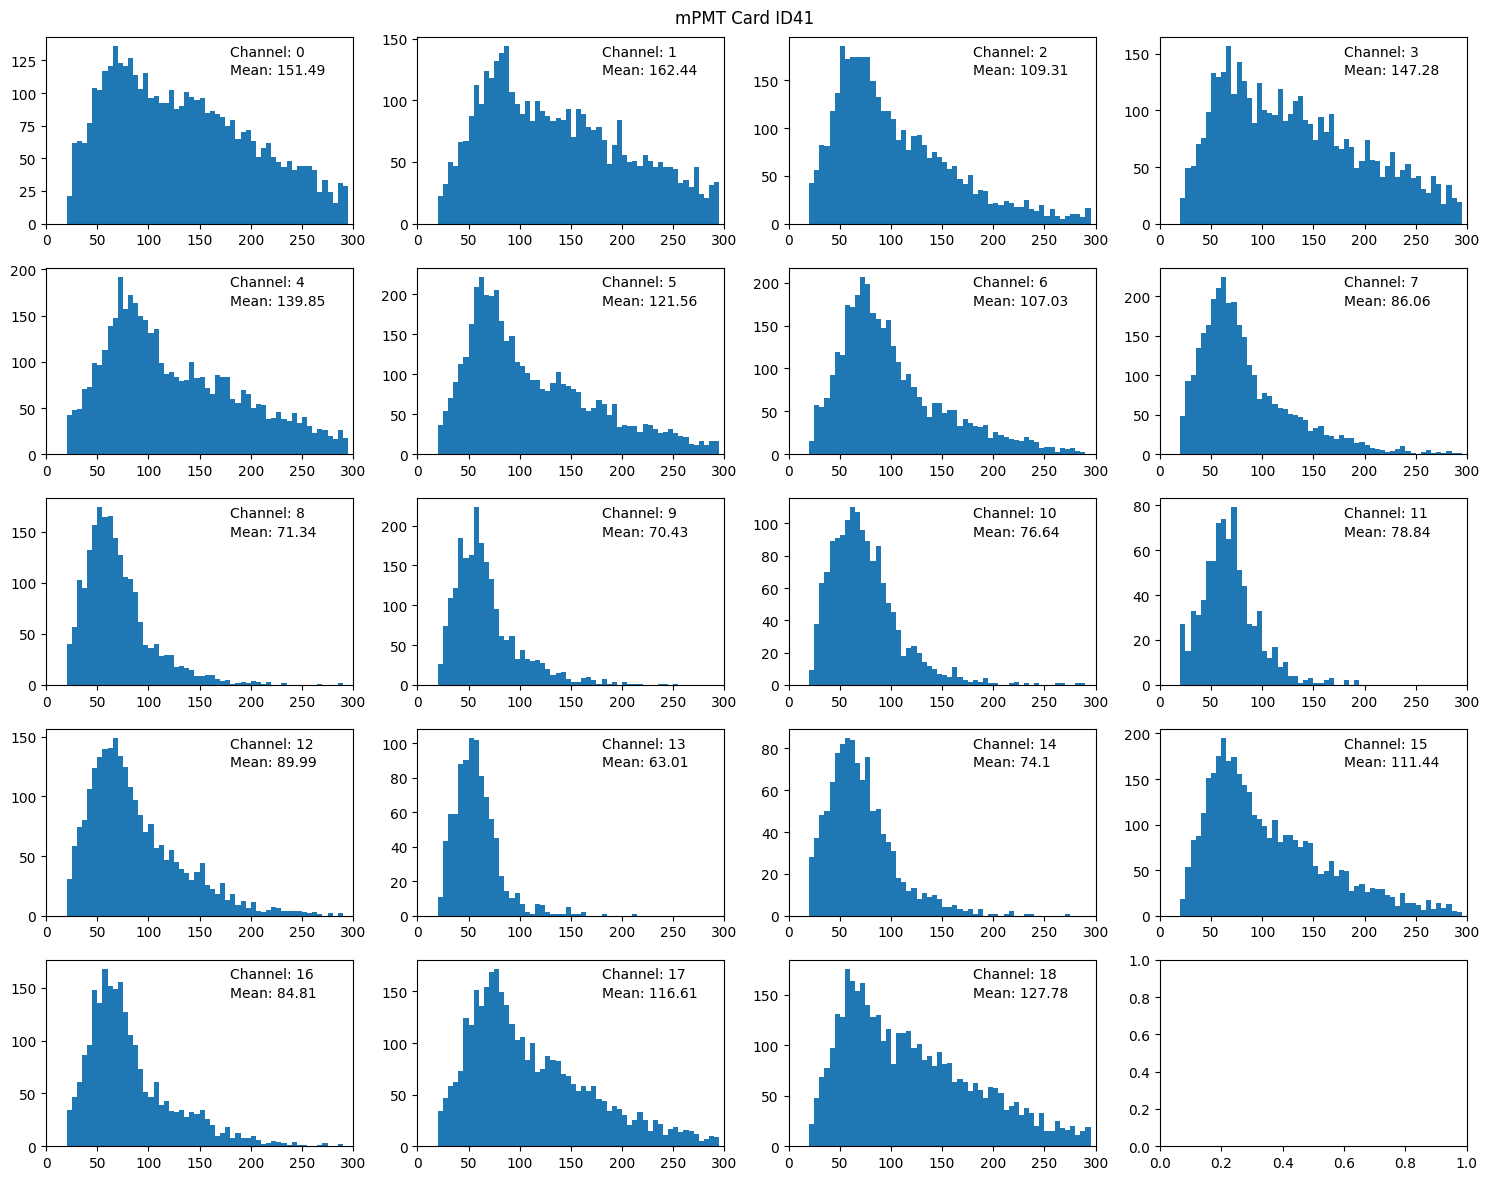

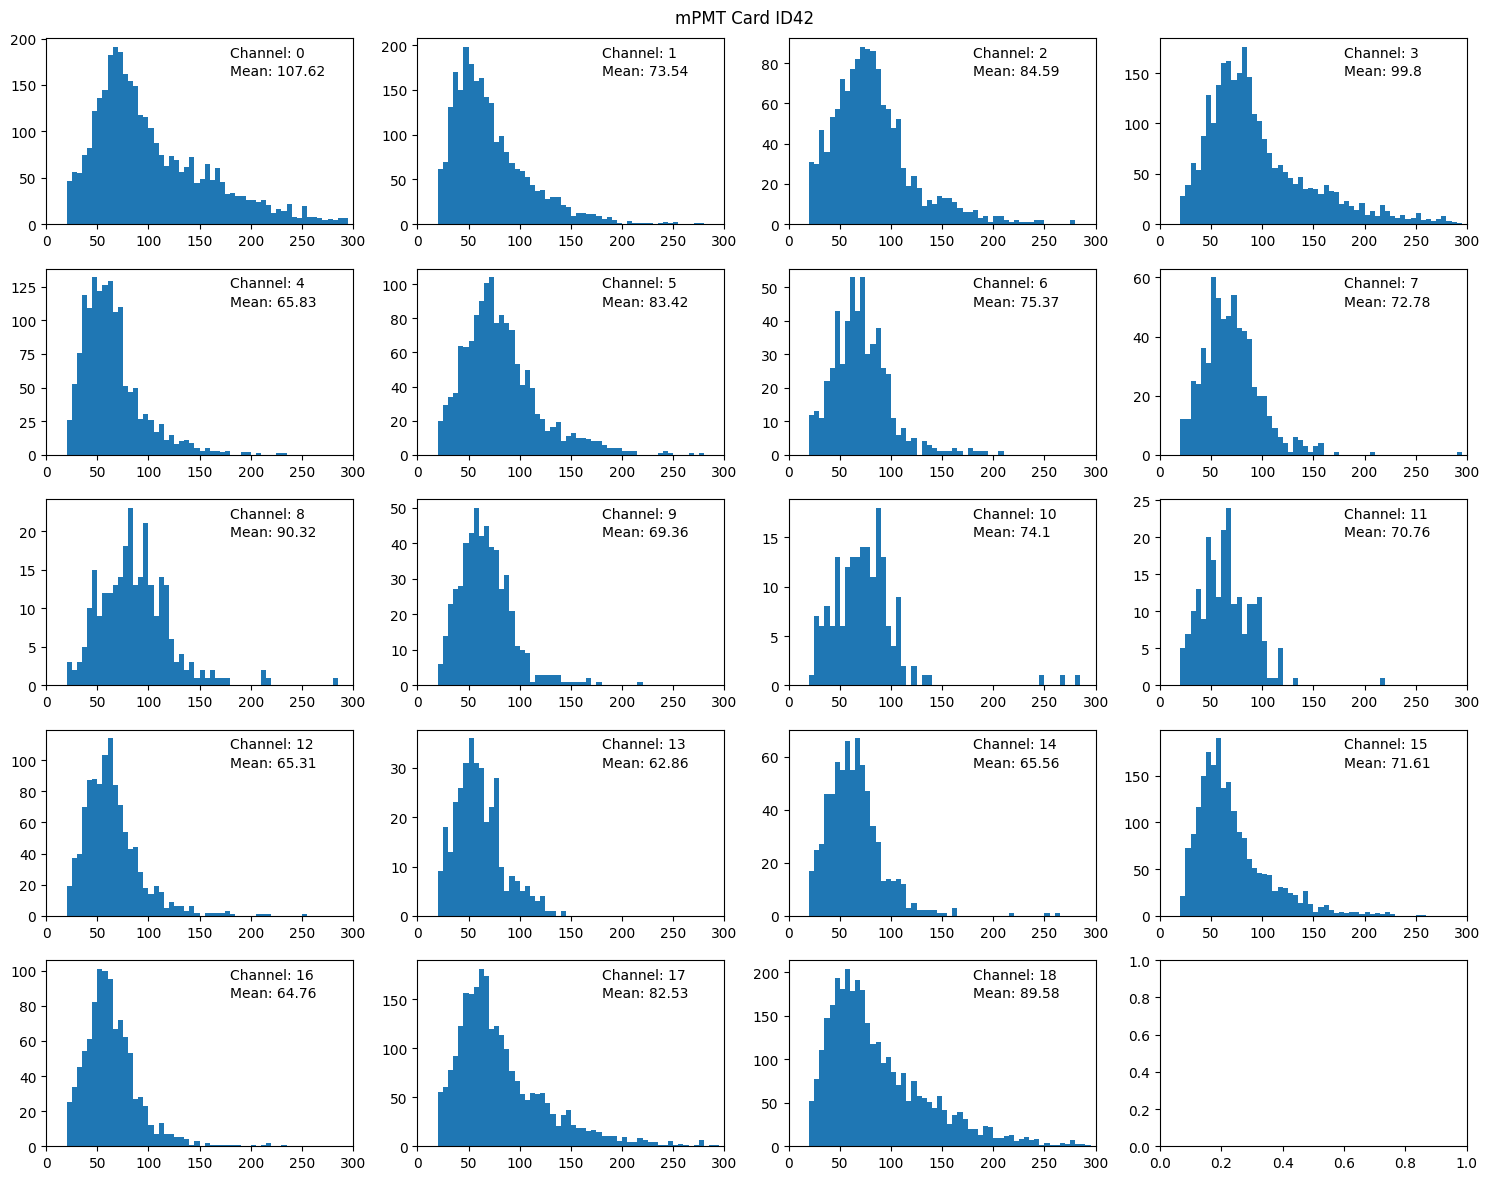

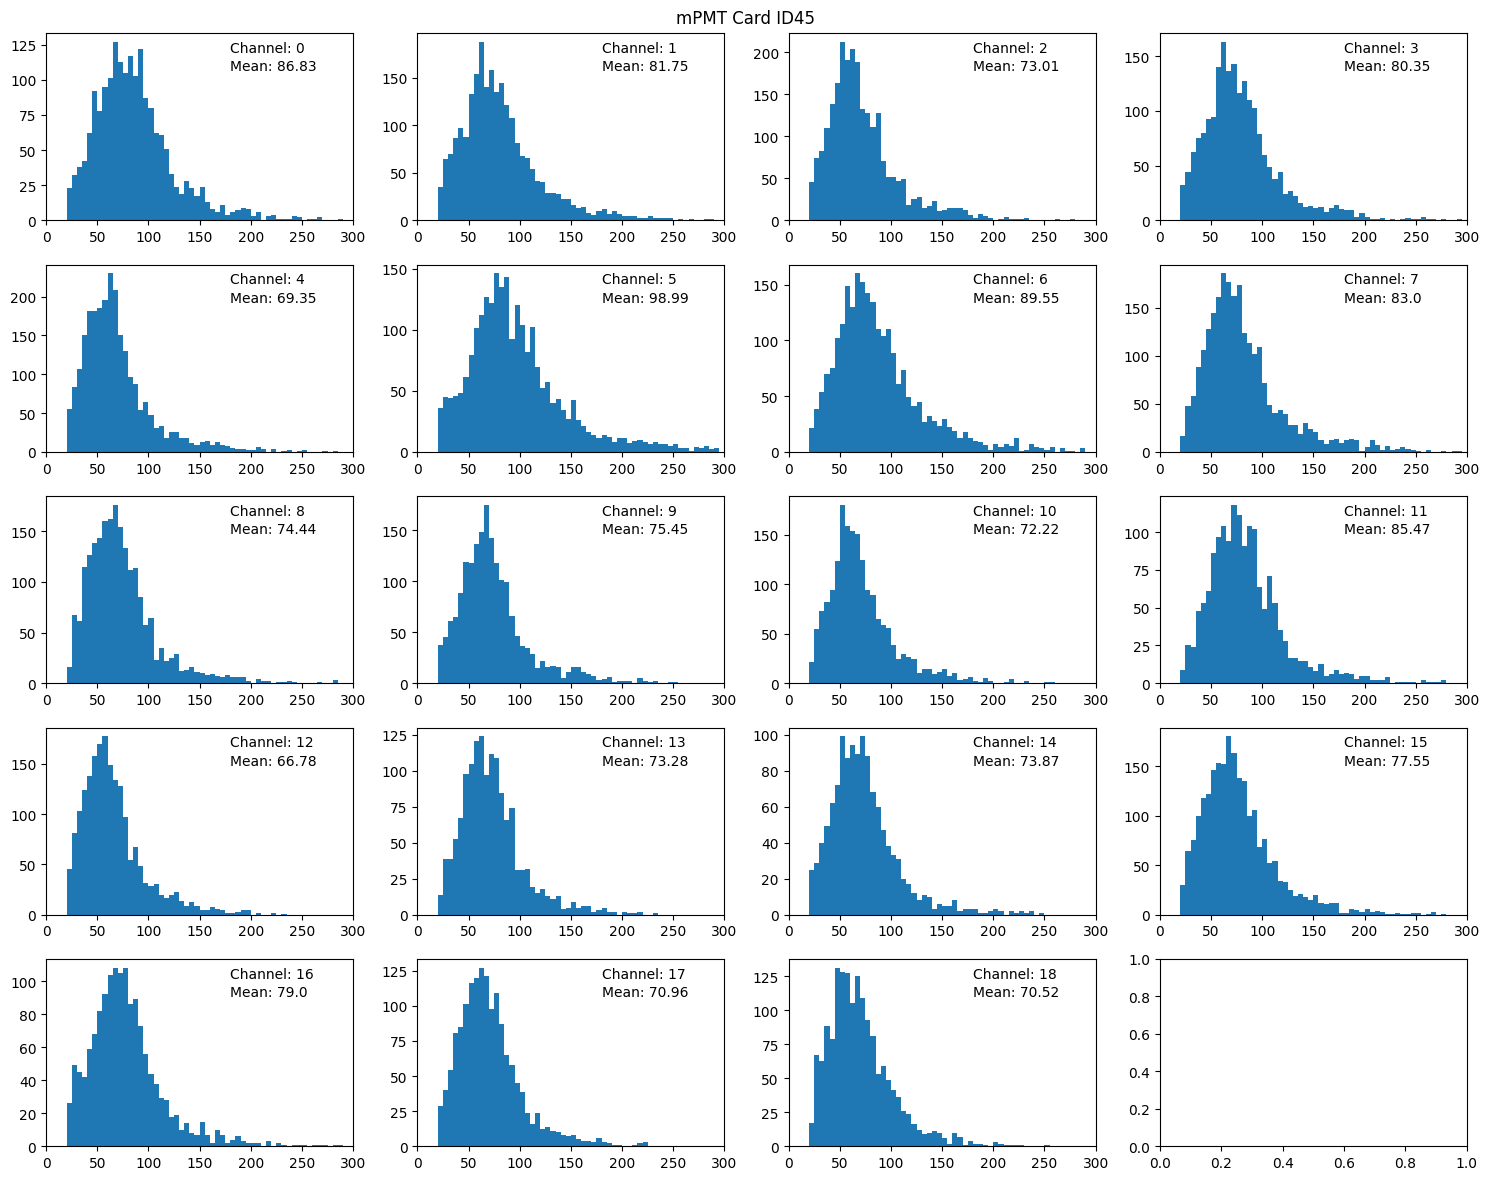

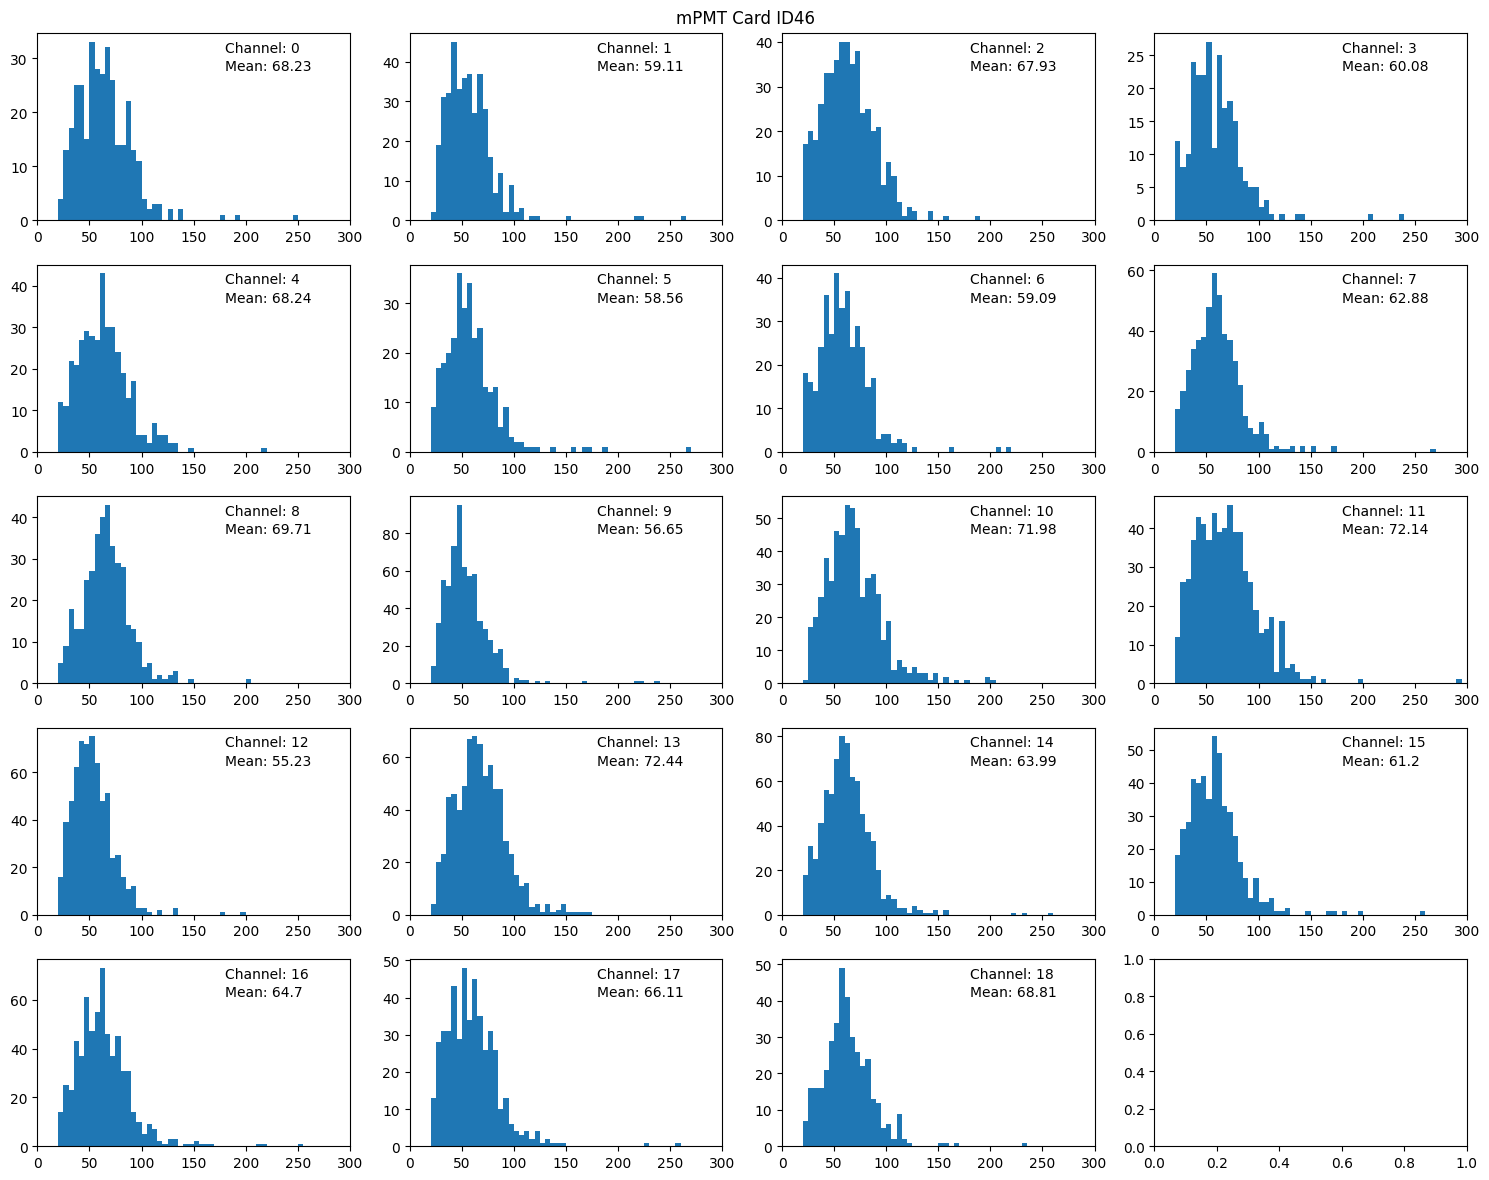

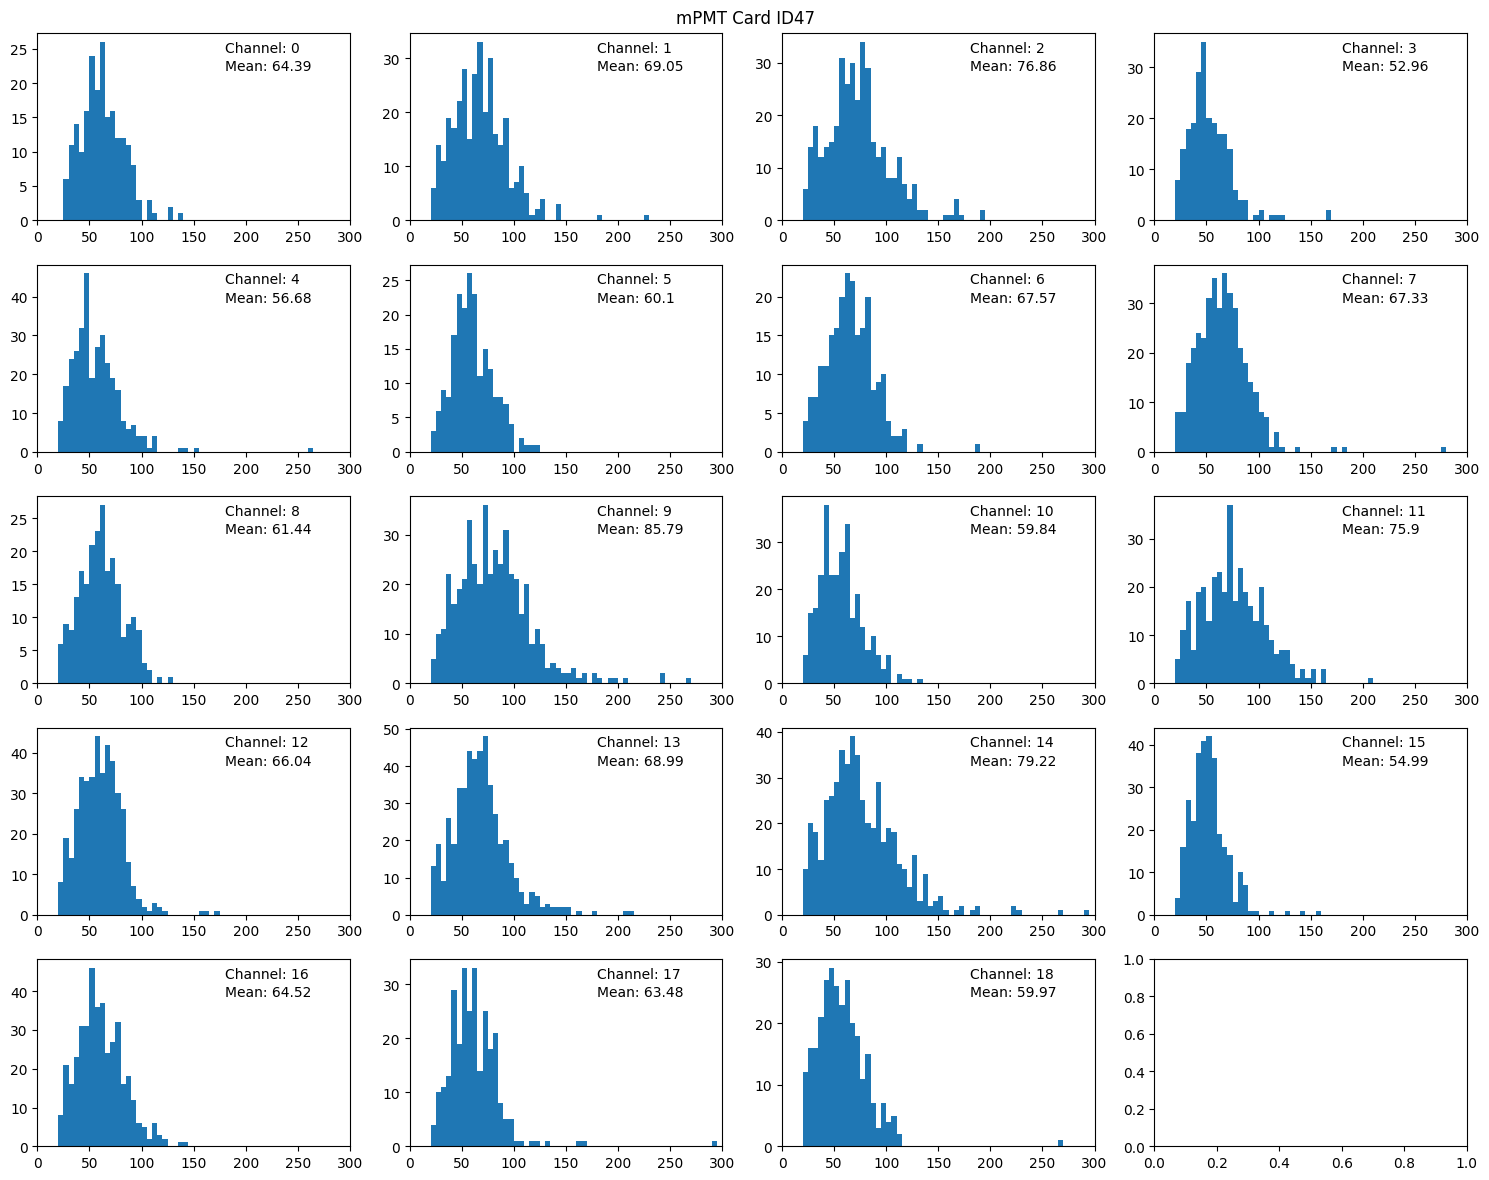

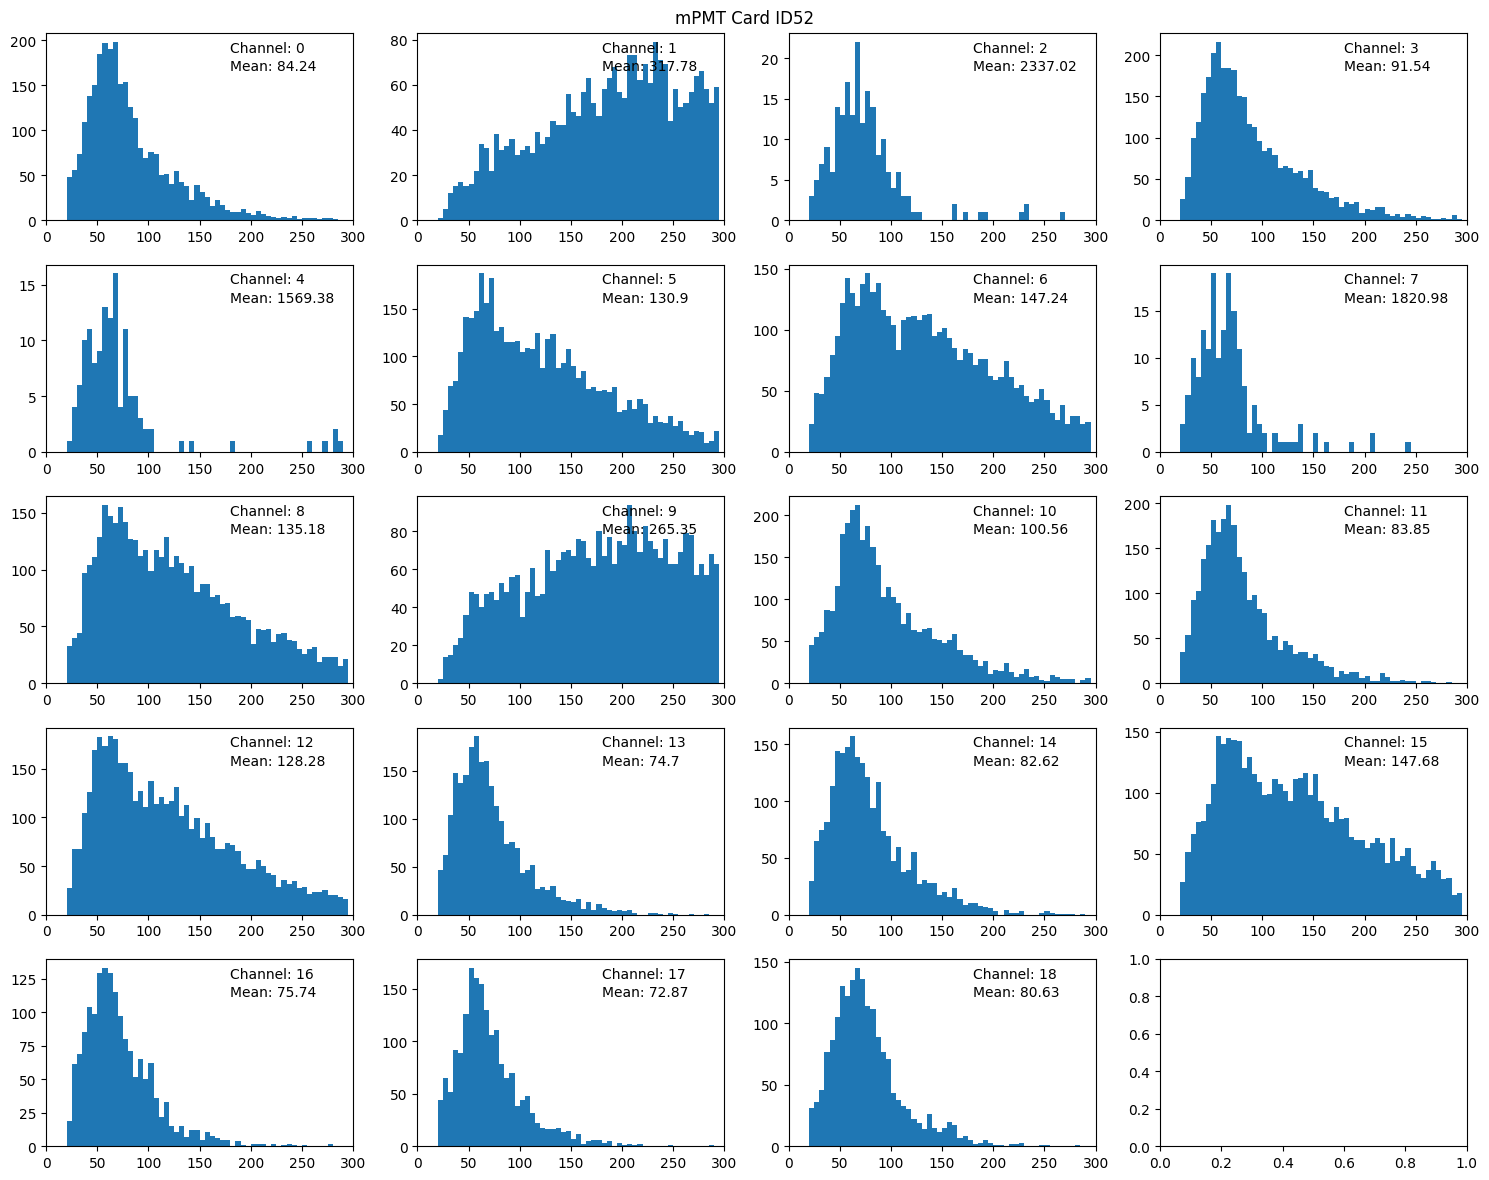

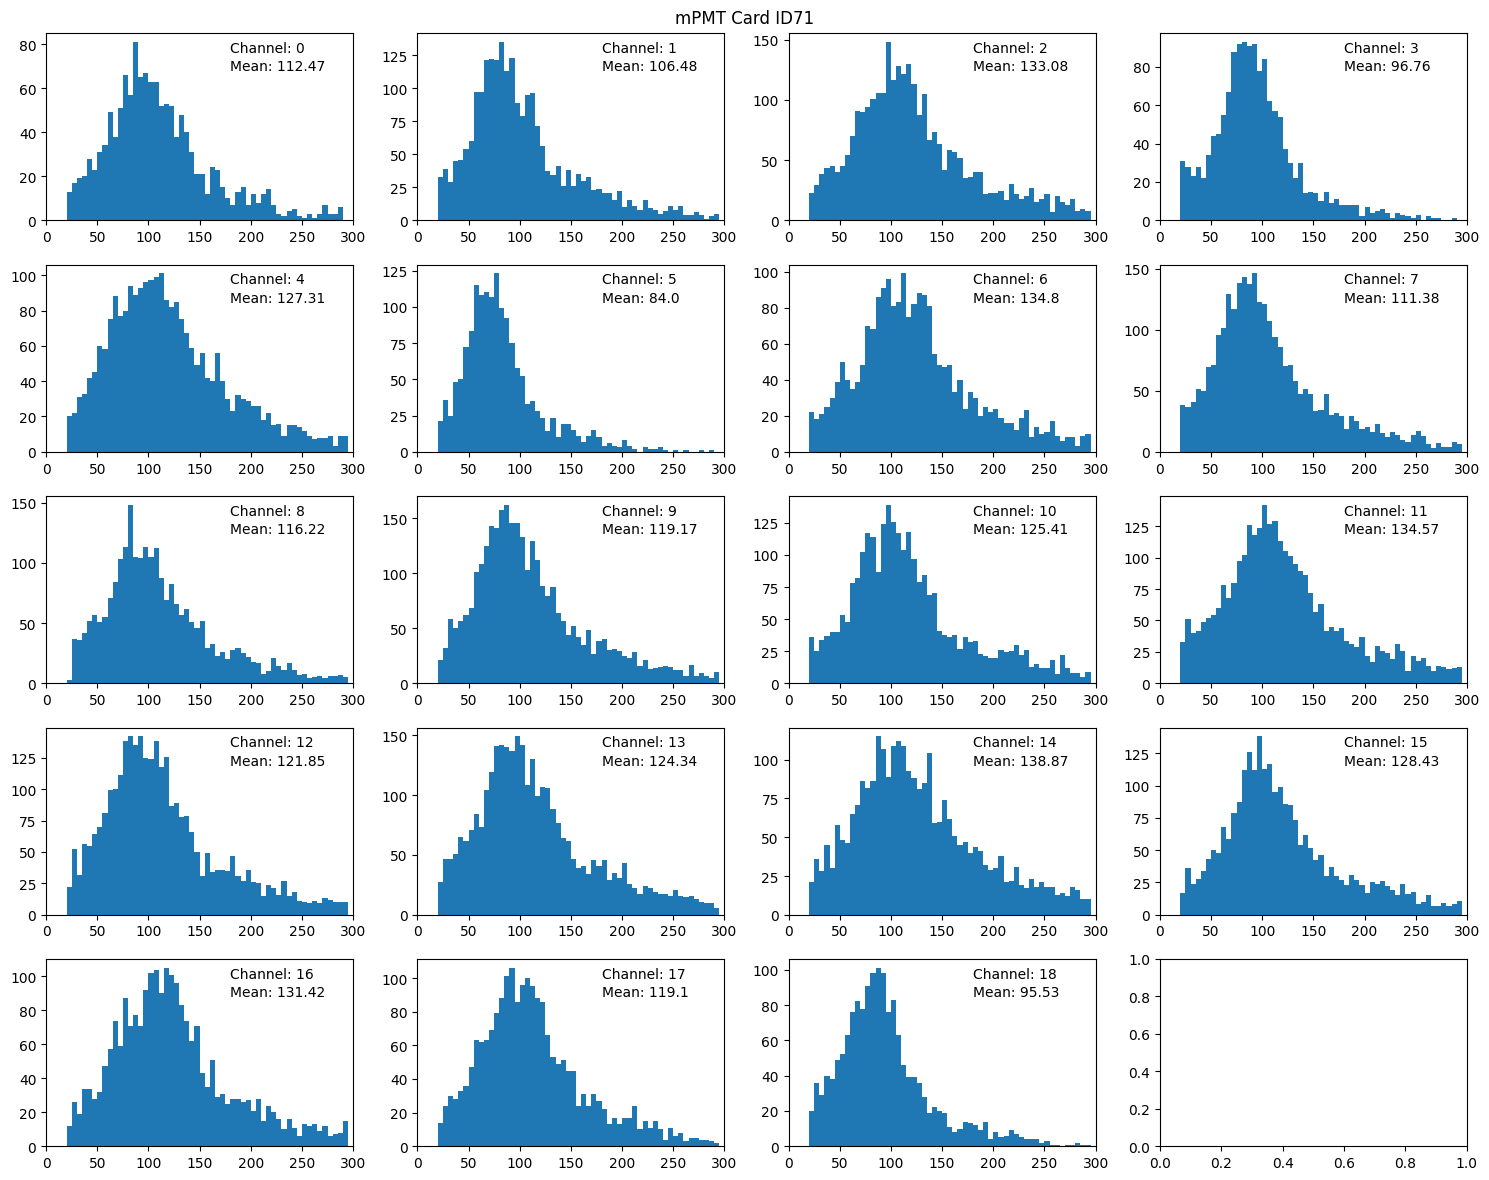

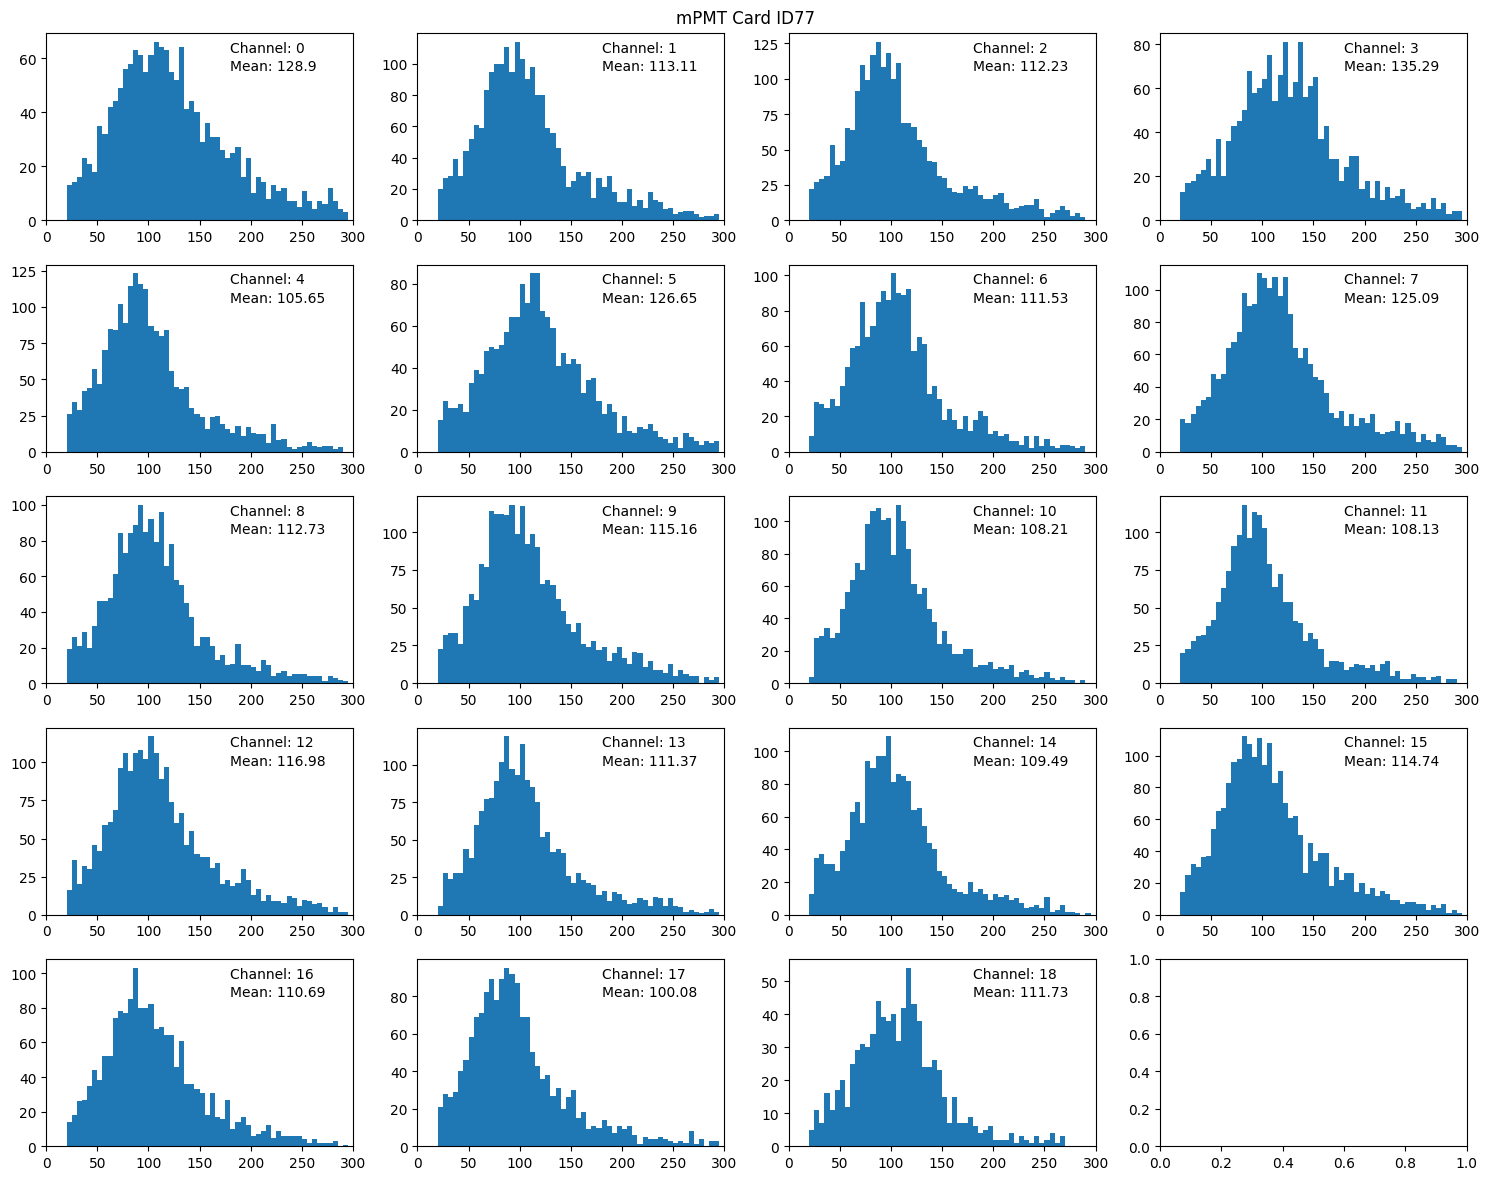

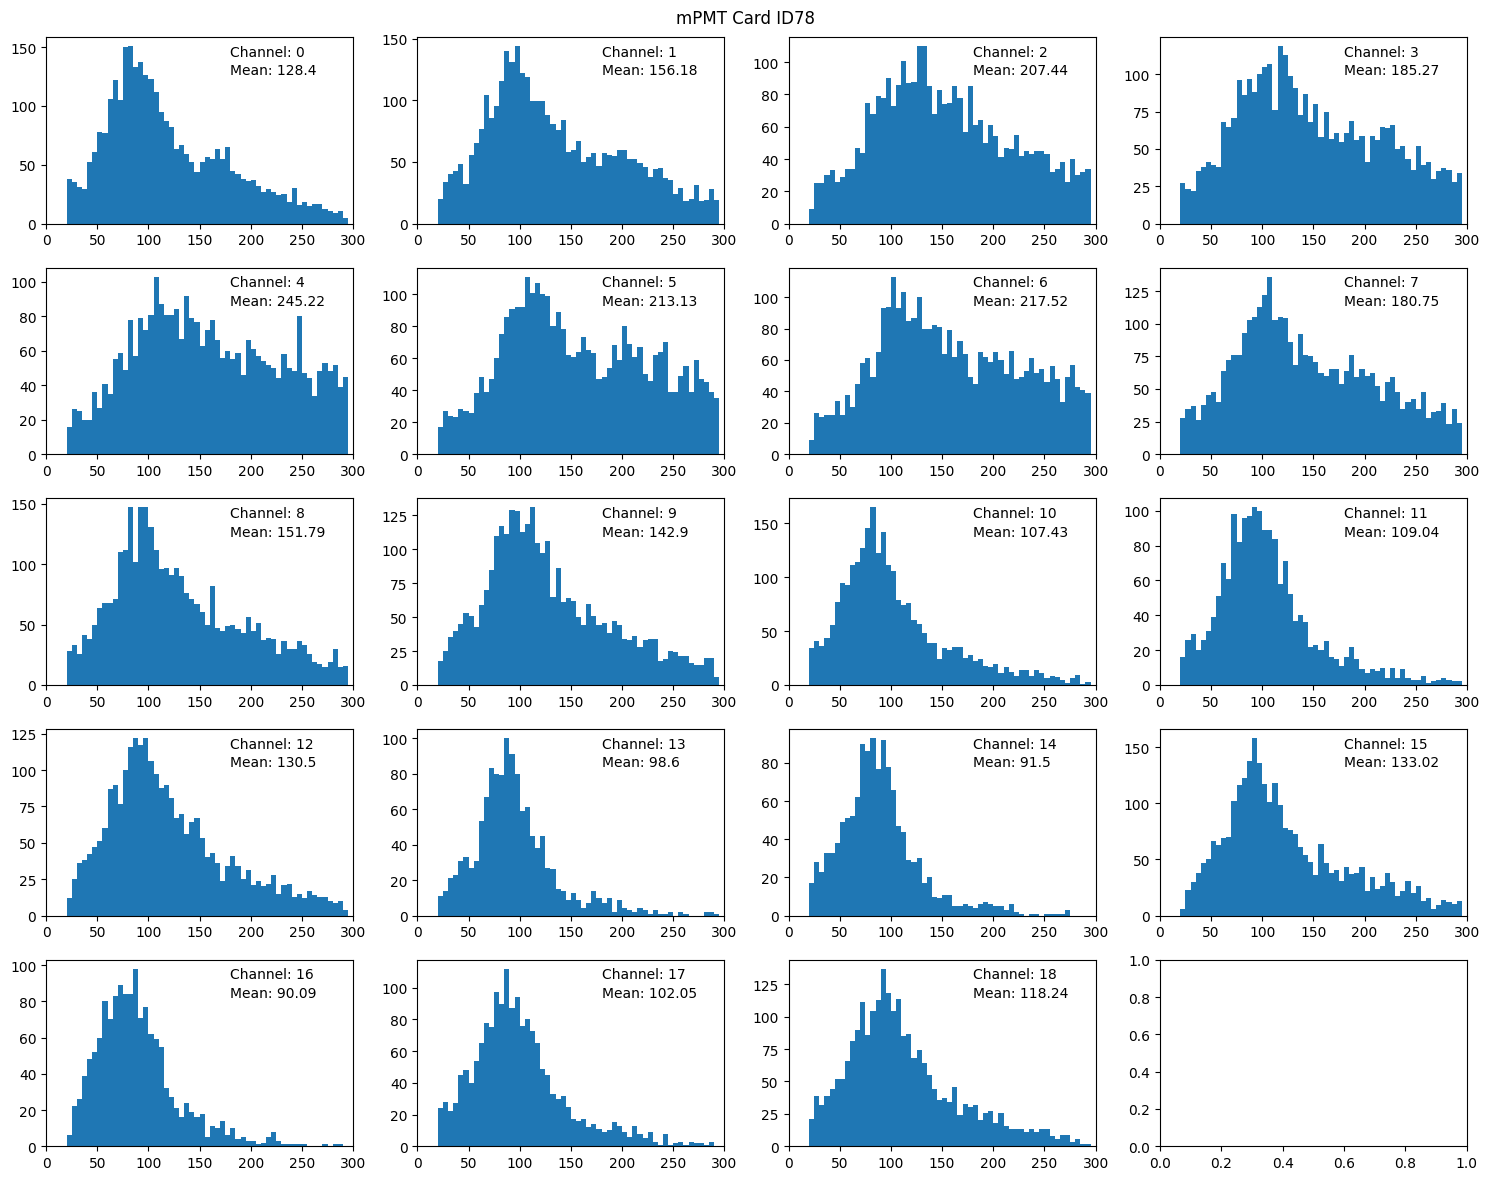

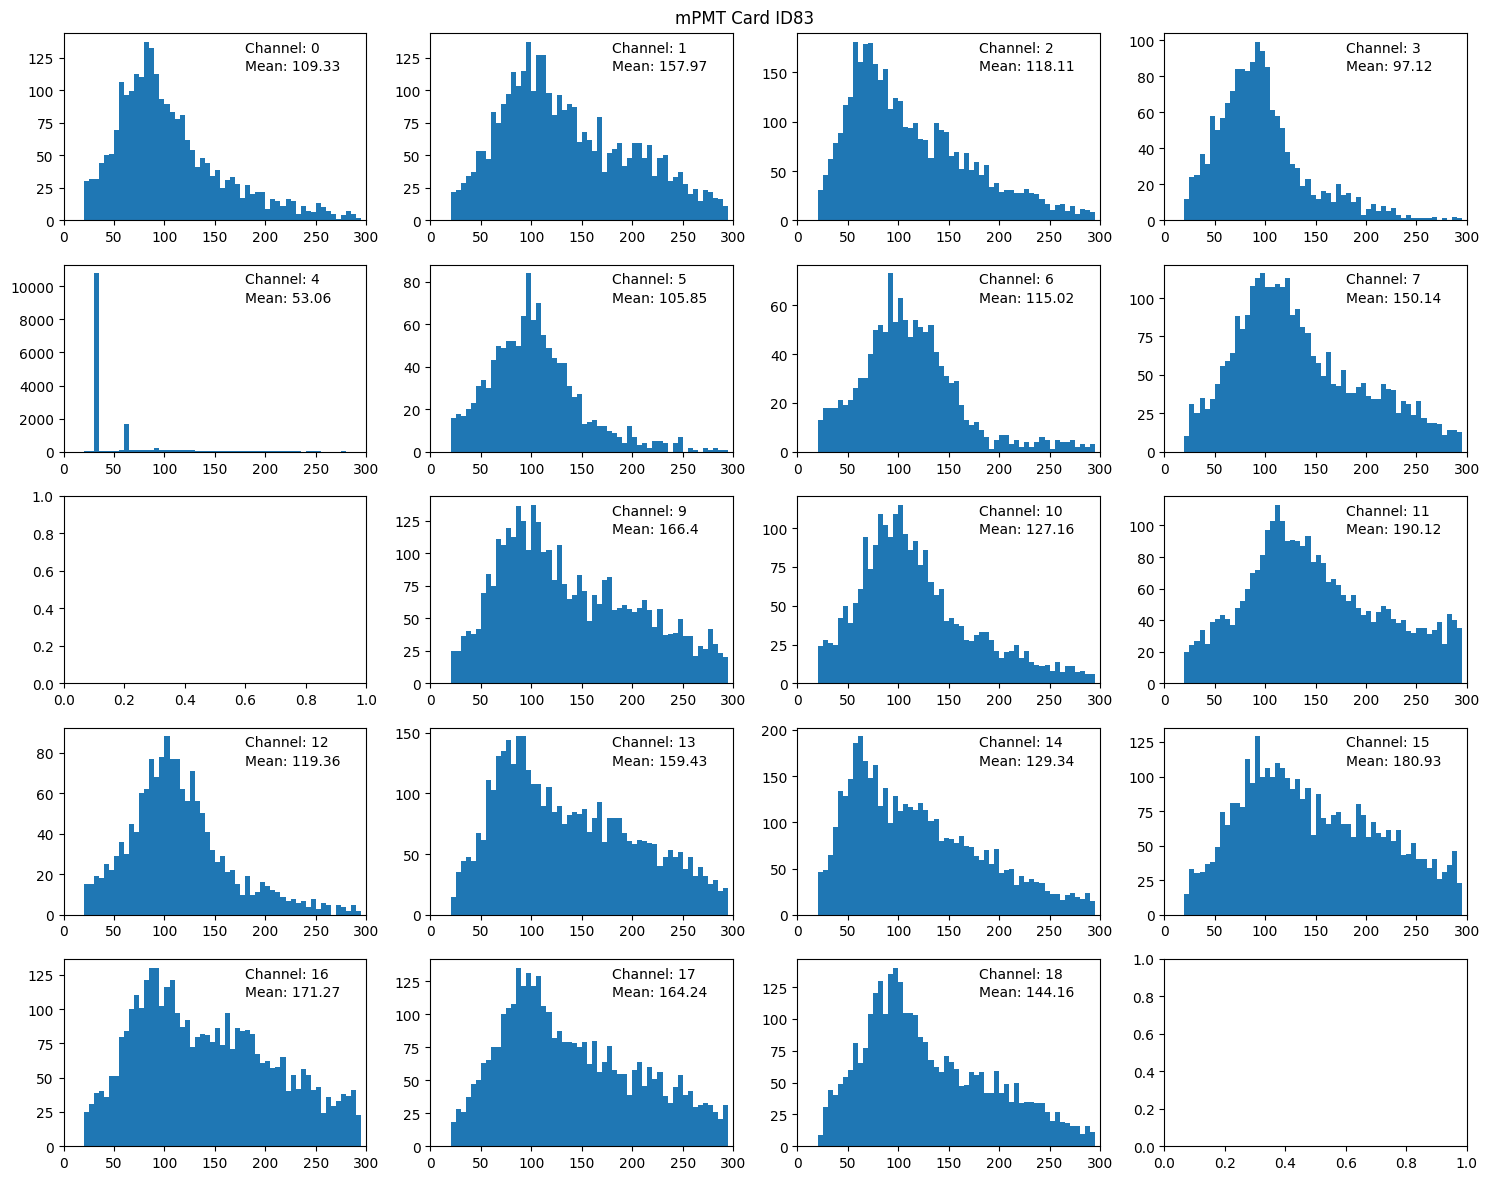

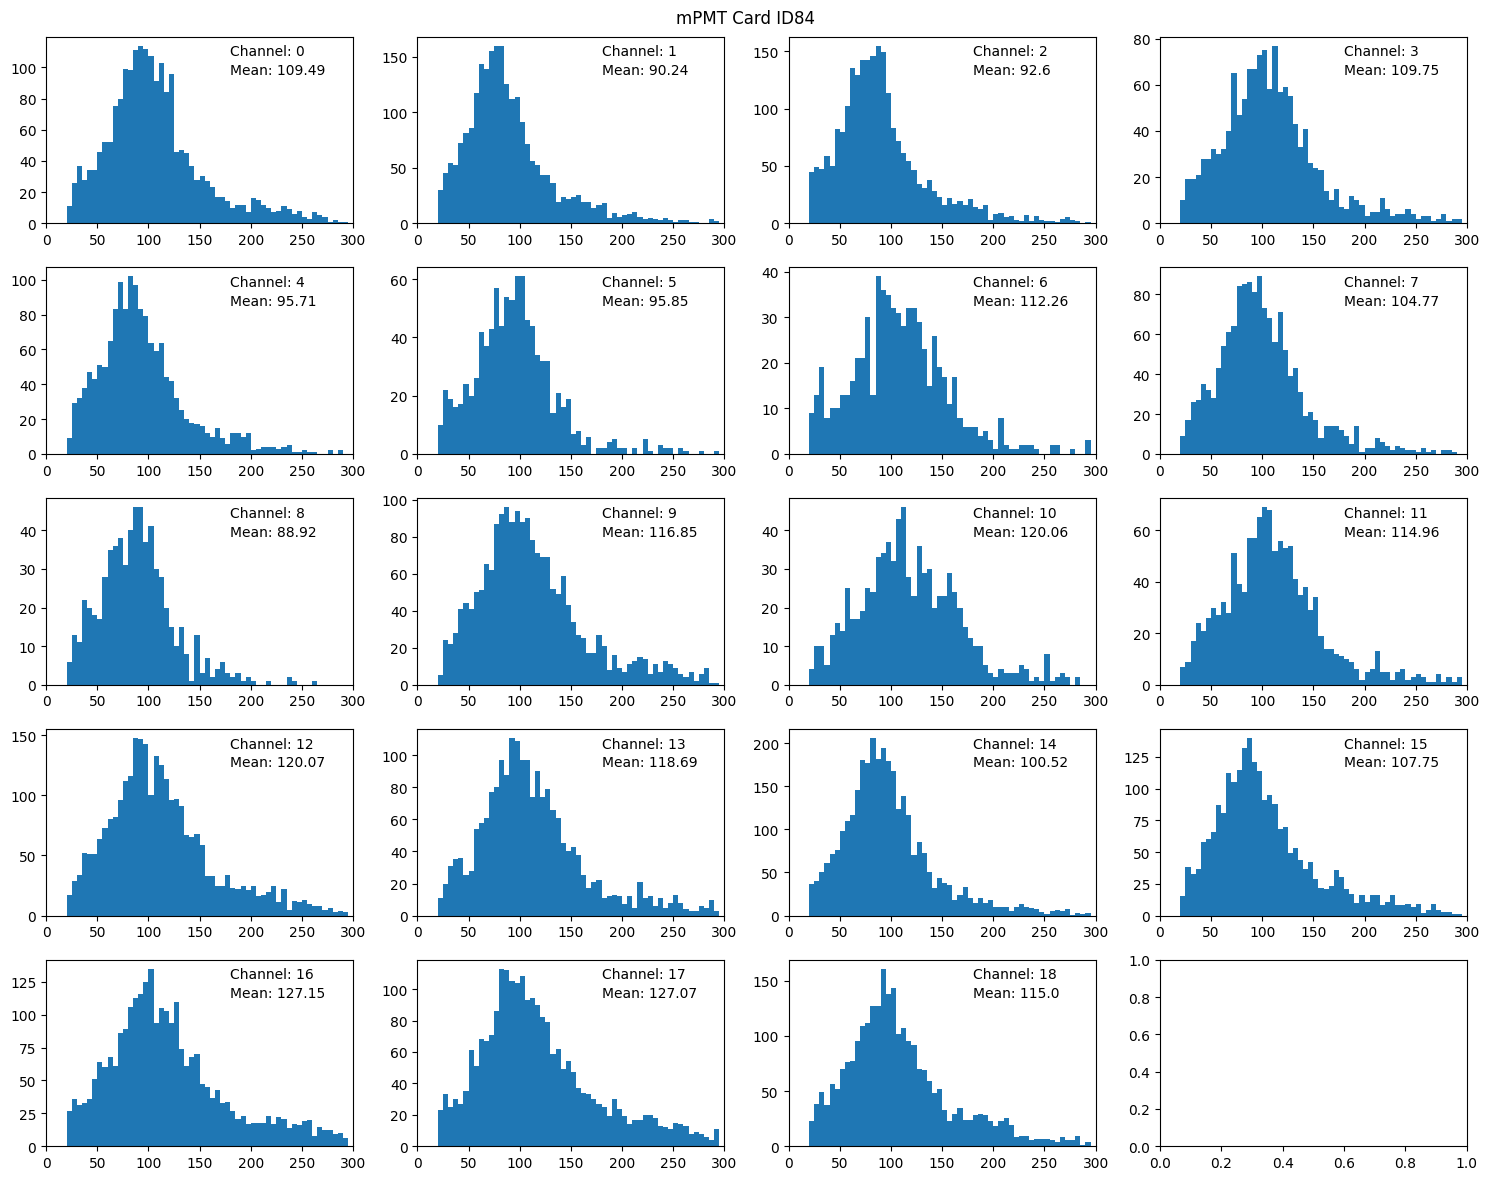

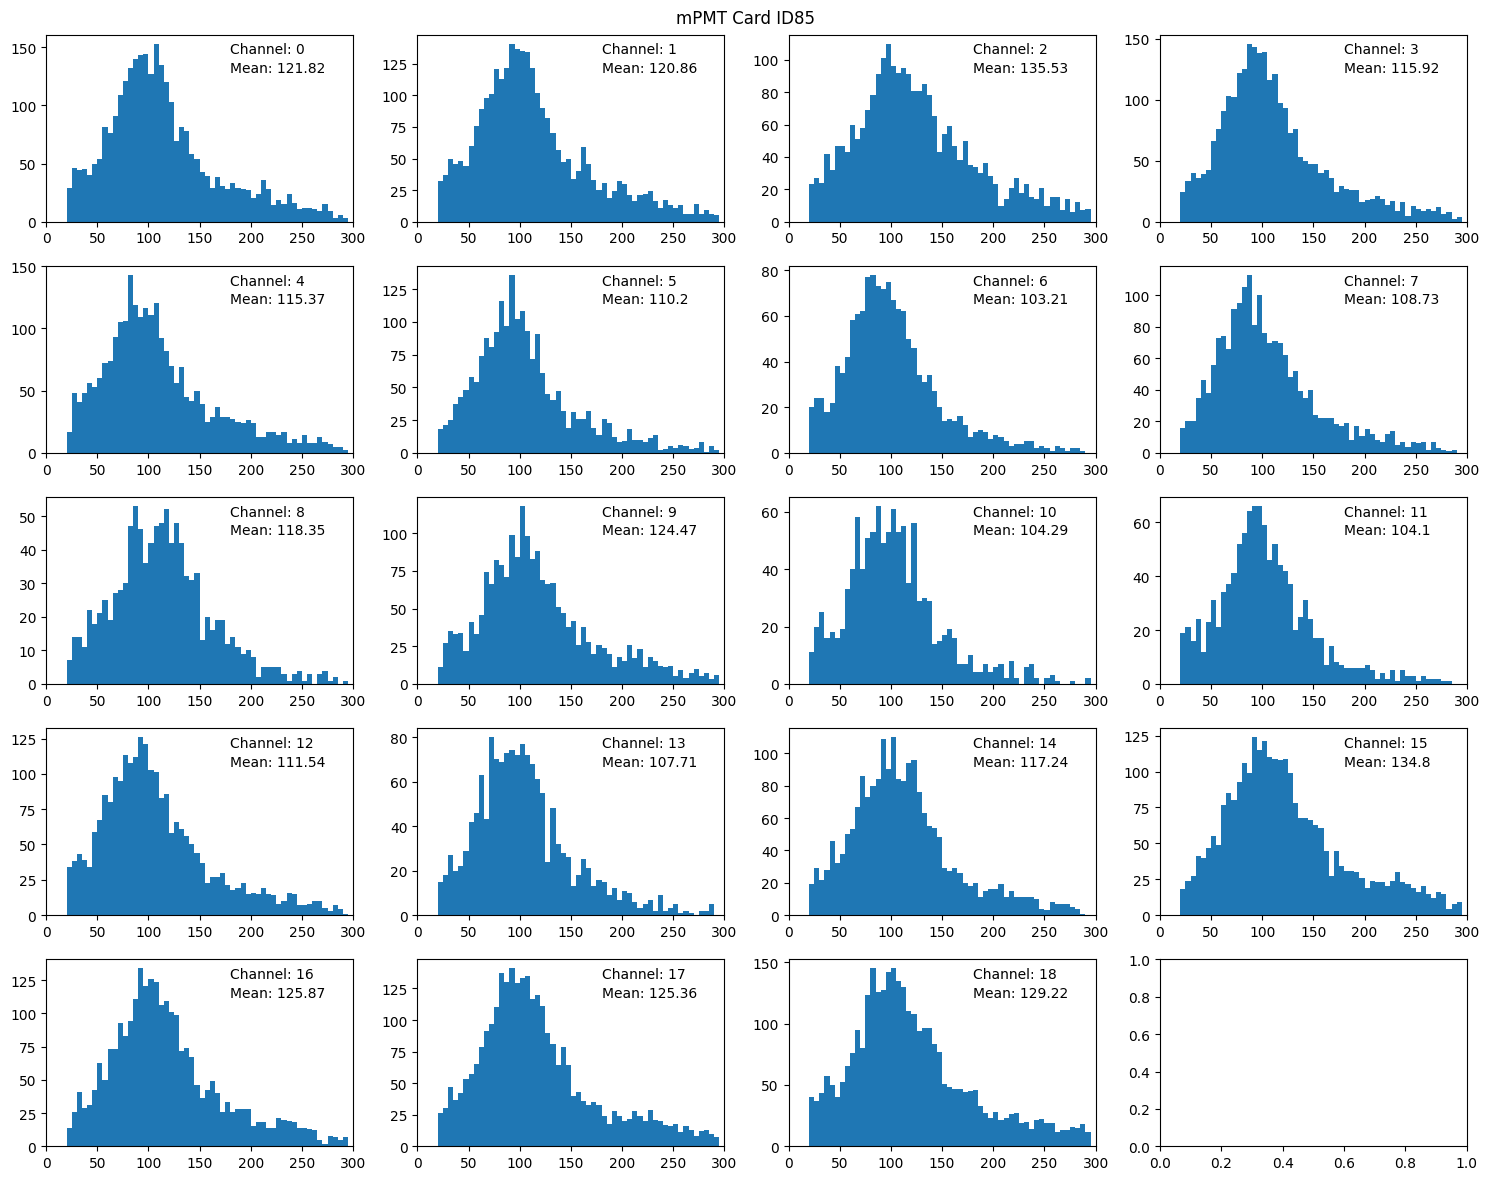

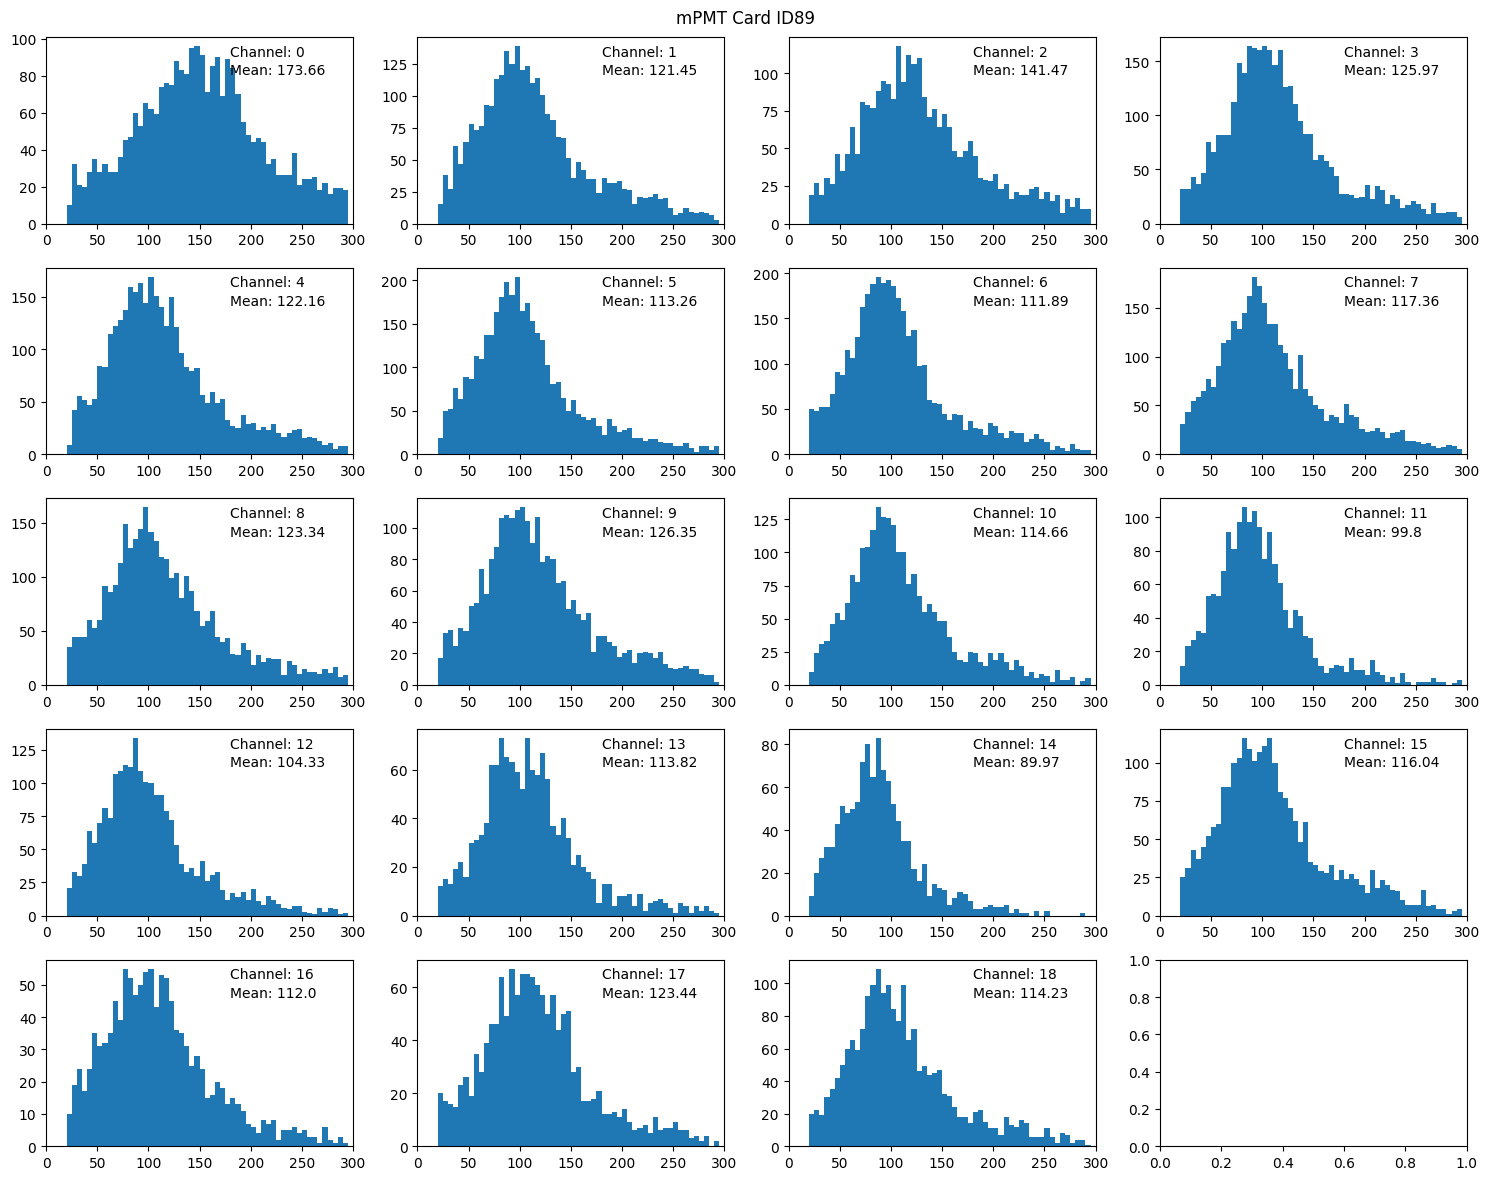

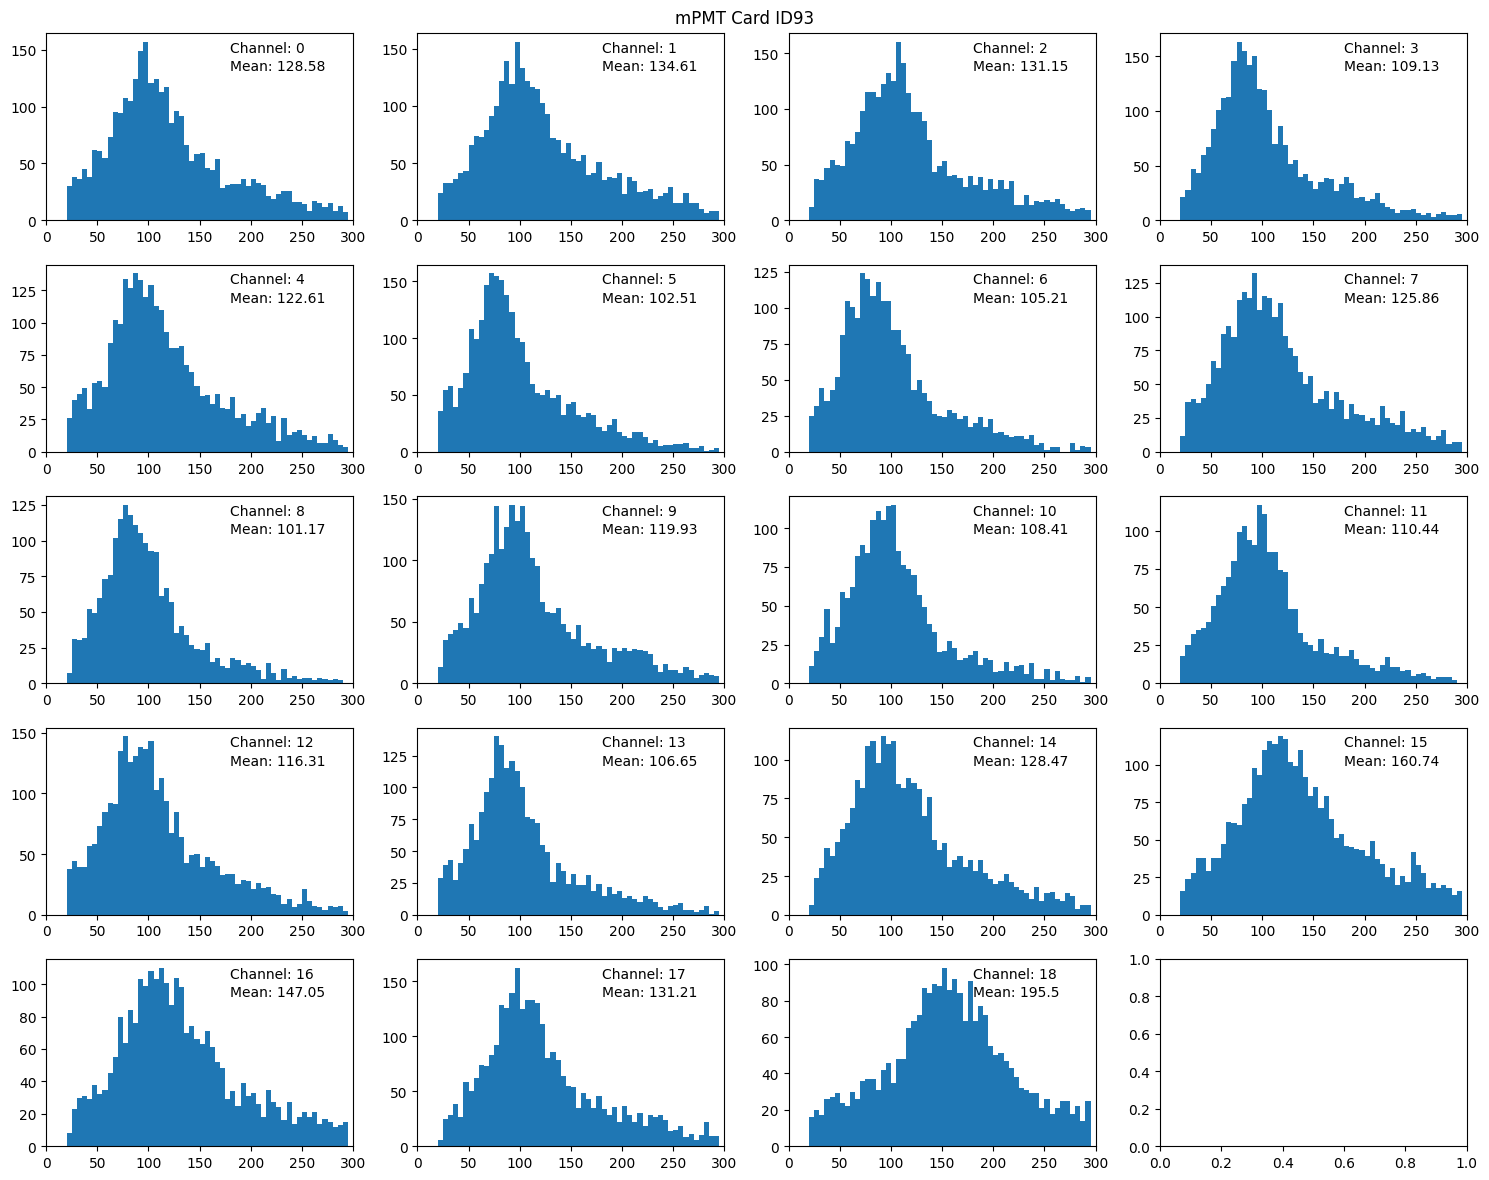

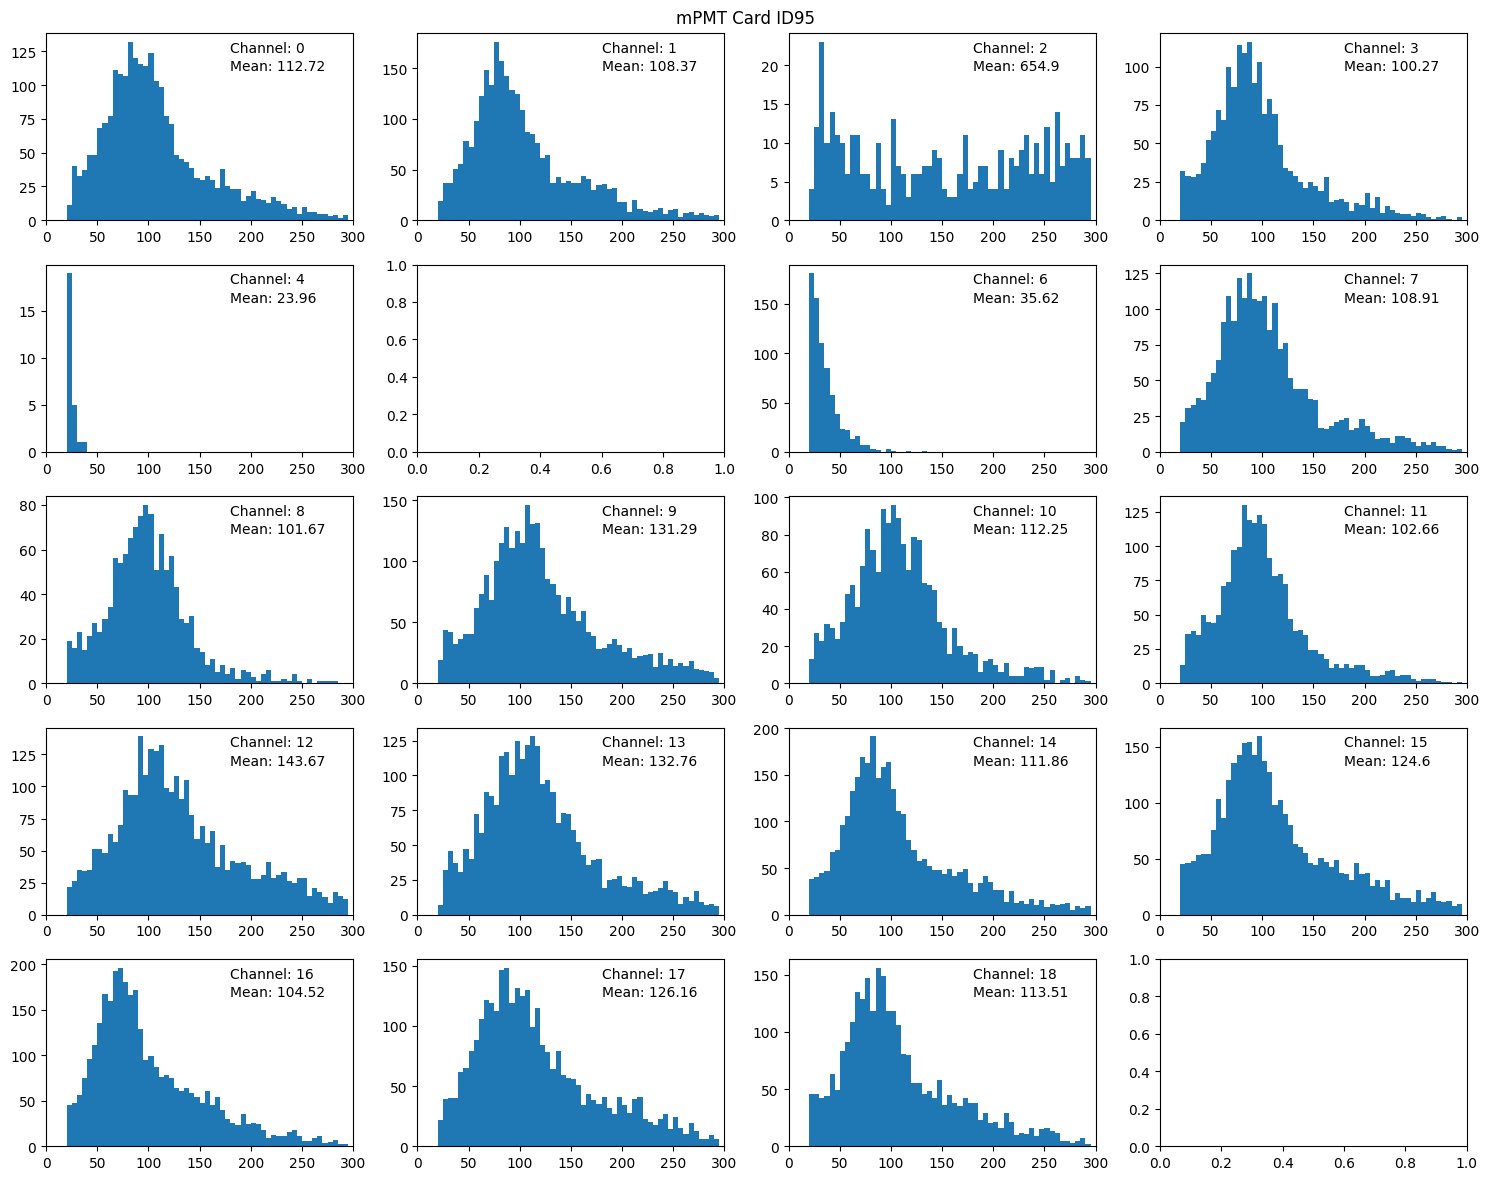

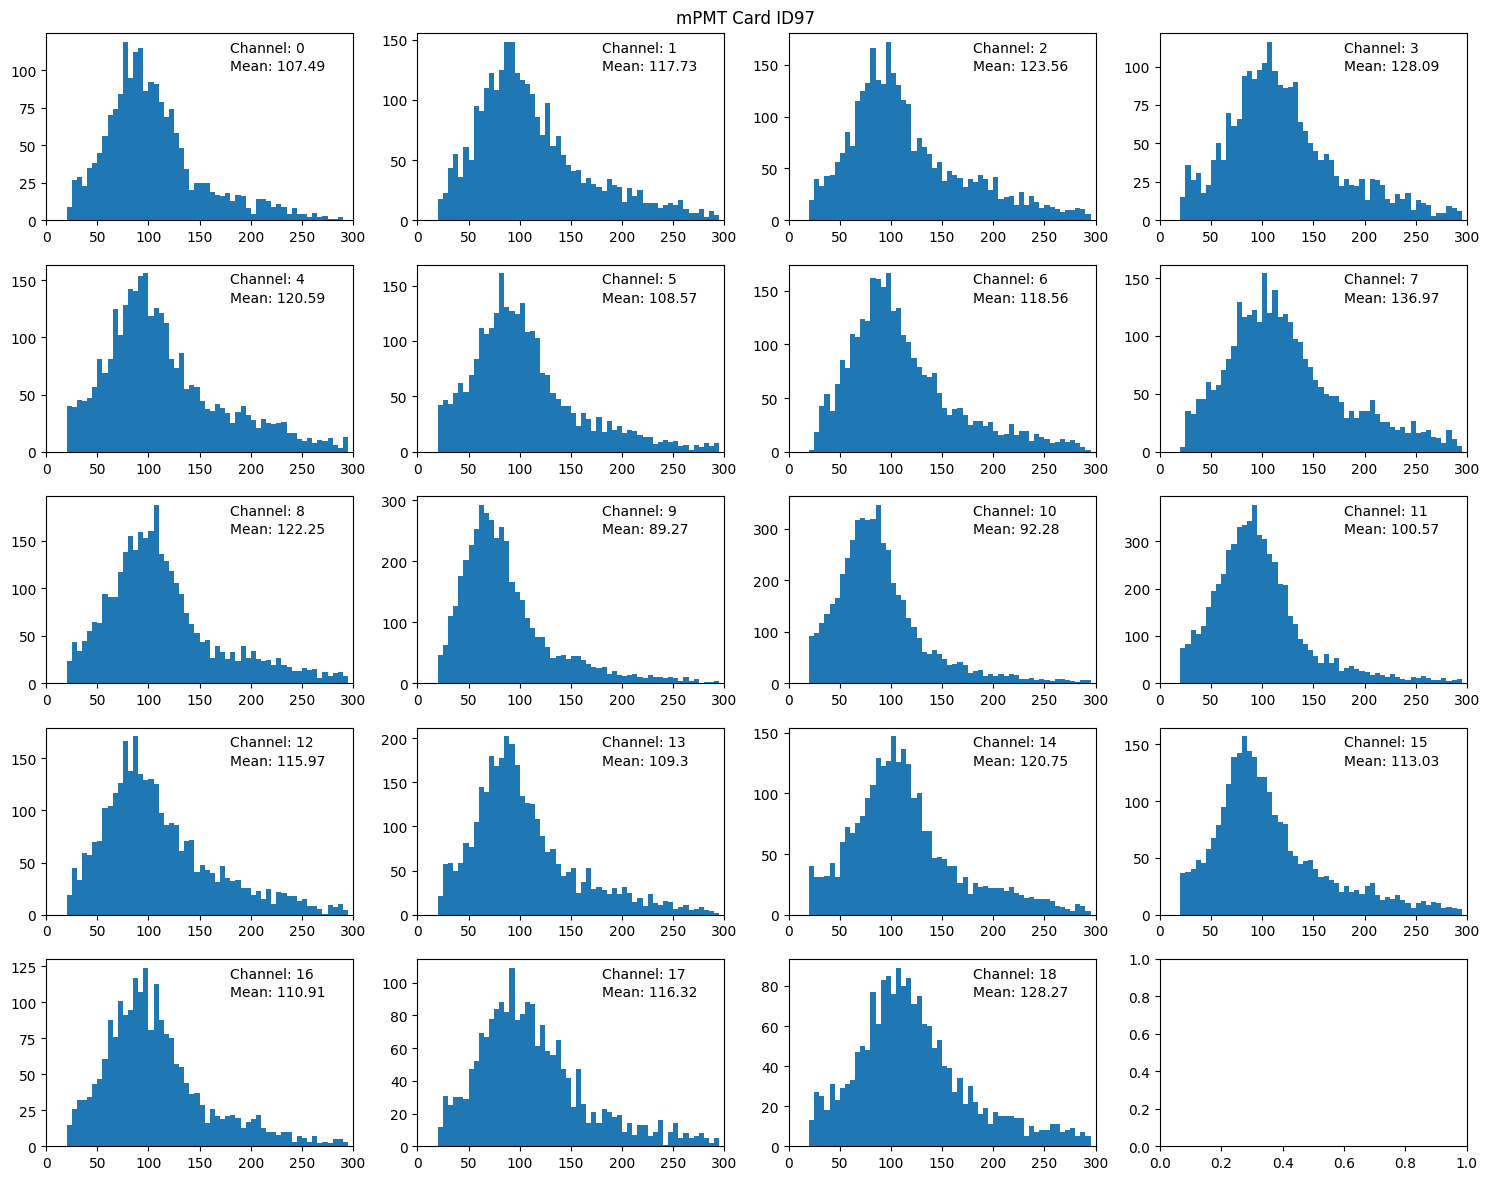

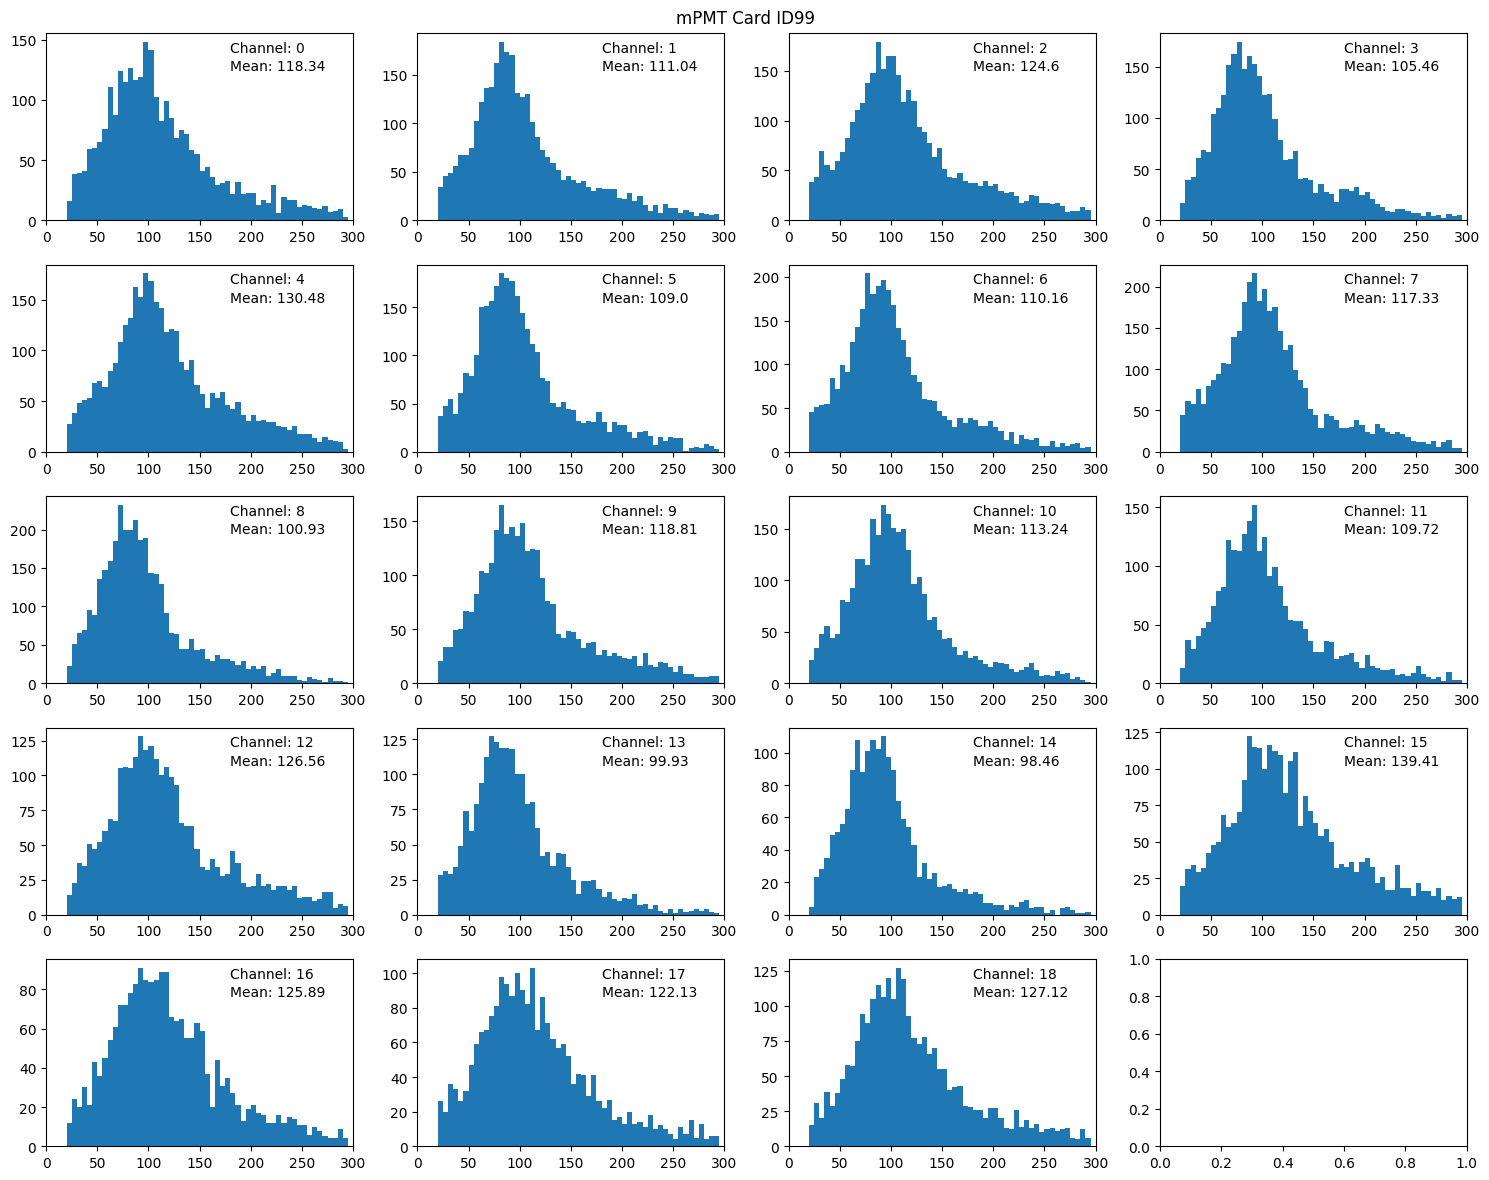

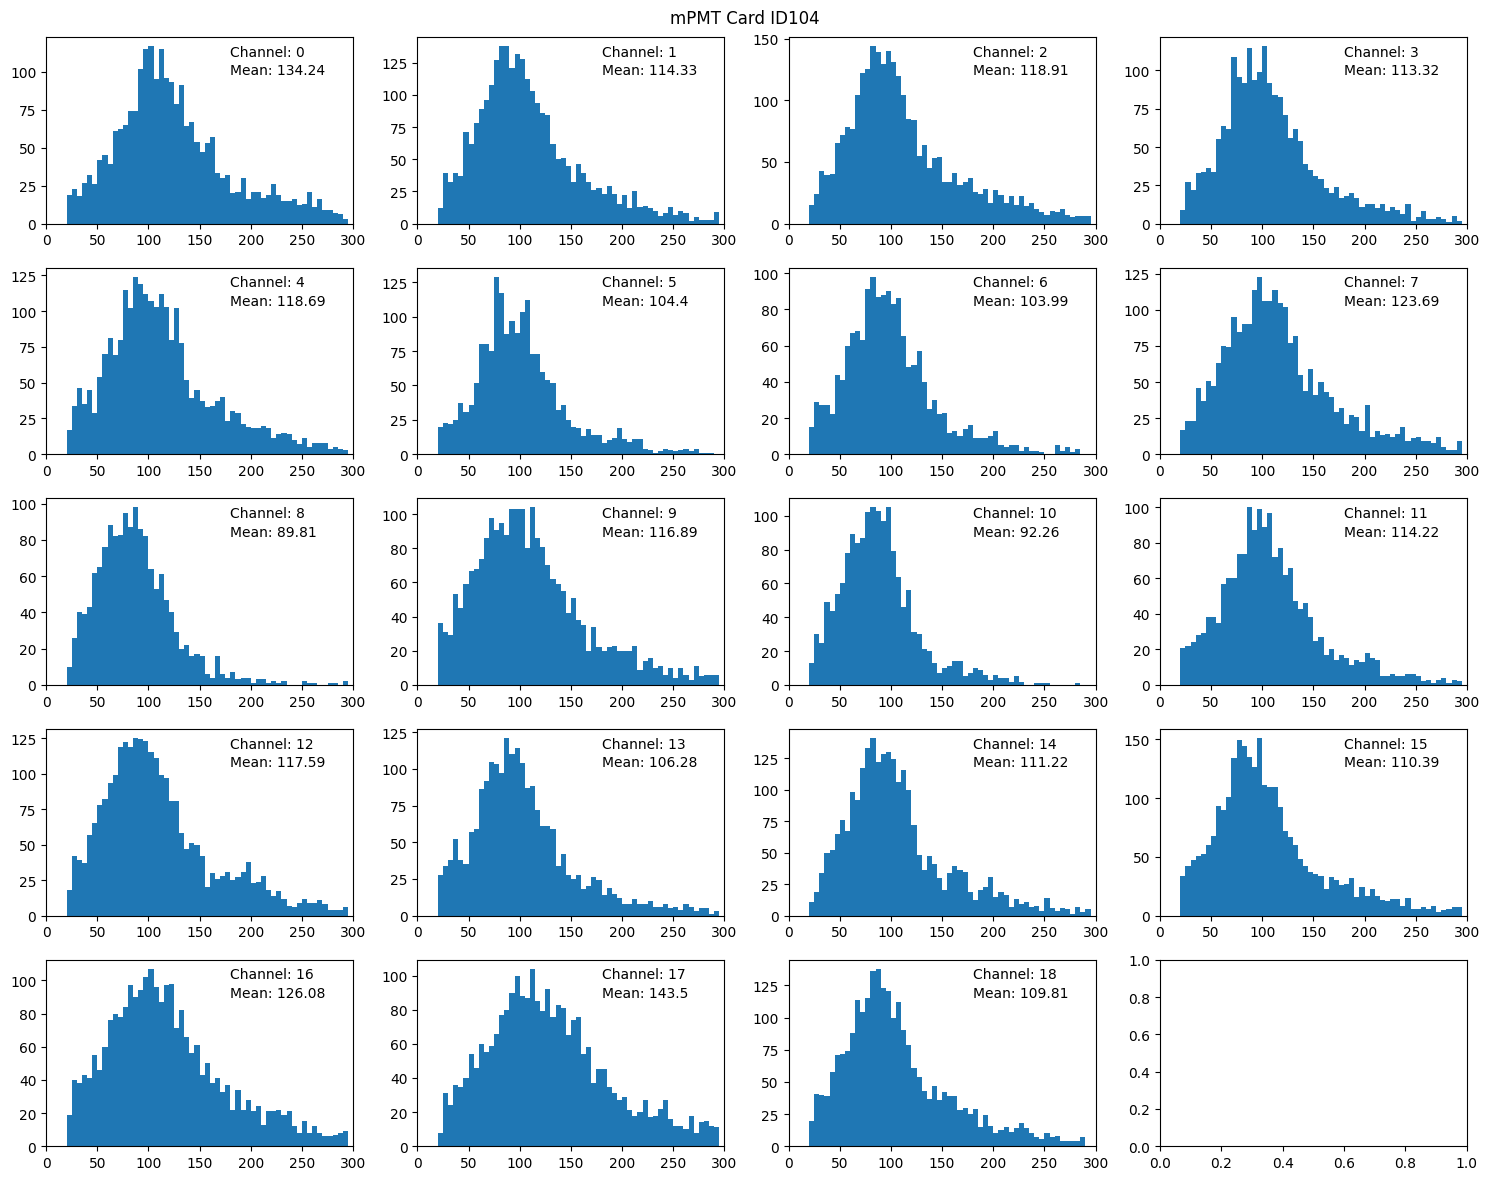

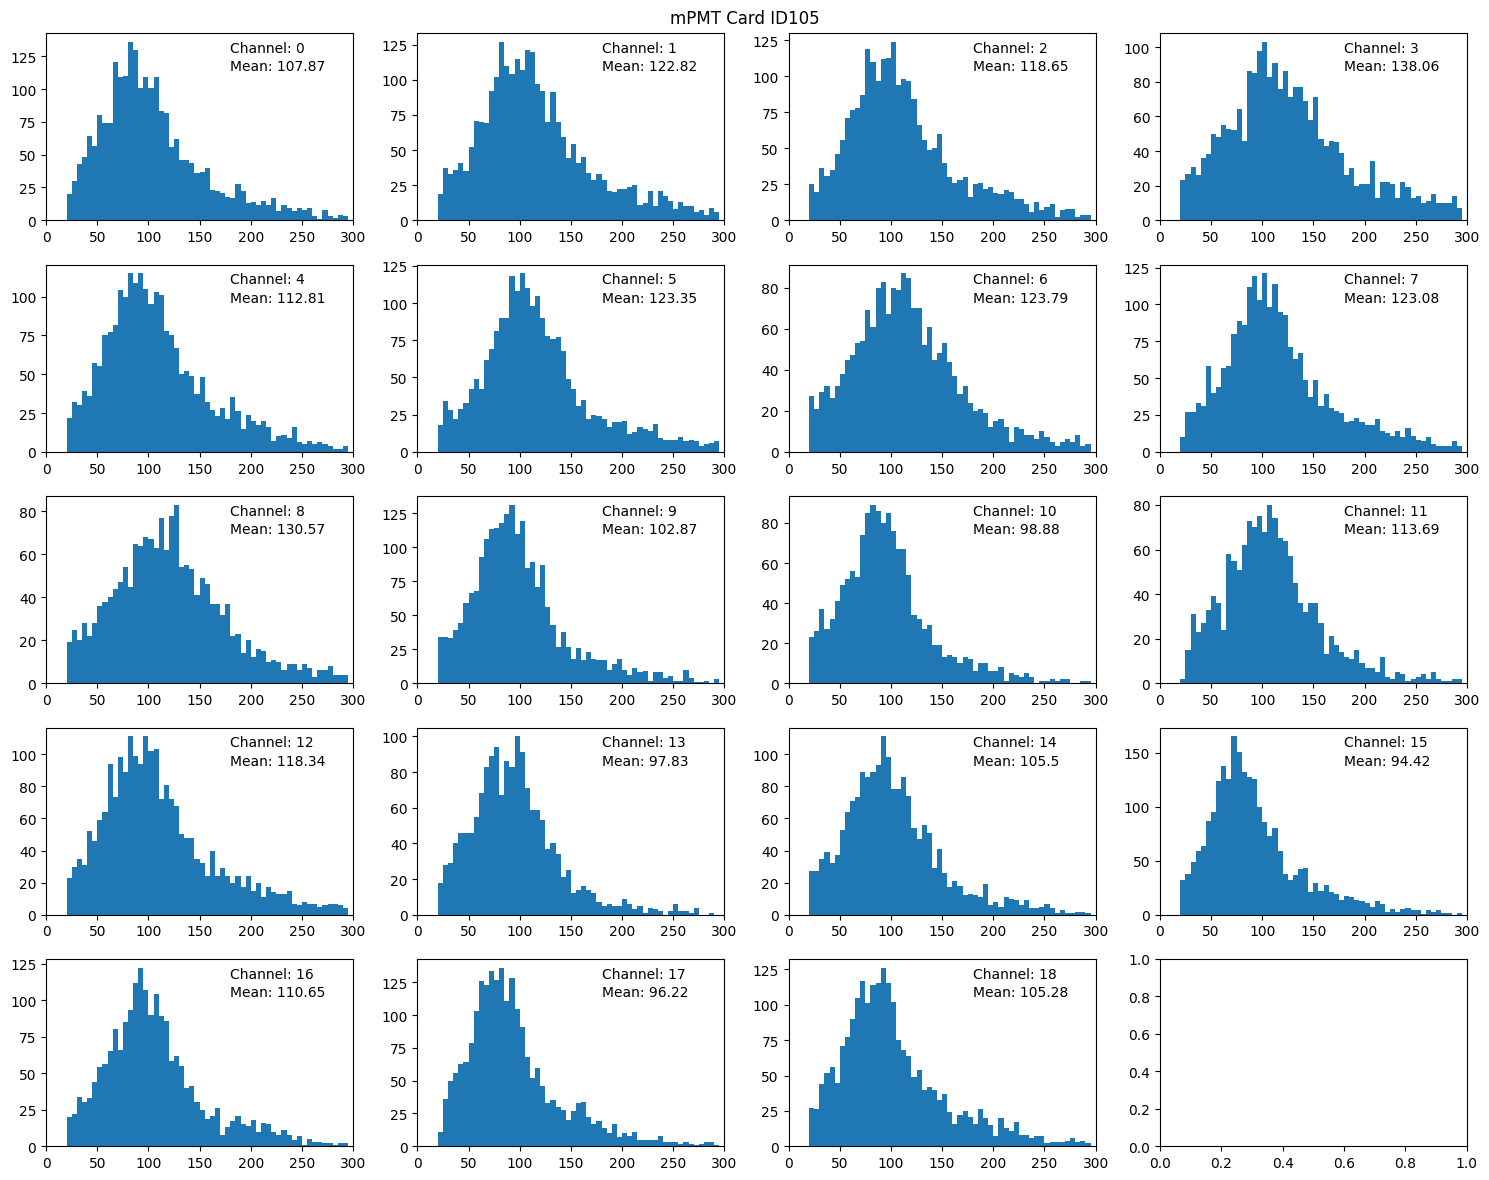

In [251]:
for mpmt in cfd_fits.keys():
    
    fig, axes = plt.subplots(5, 4, figsize=(15, 12))
    
    # move suptitle down a bit
    fig.subplots_adjust(top=0.95)
    plt.suptitle('mPMT Card ID' + str(mpmt))

    
    for channel in cfd_fits[str(mpmt)].keys():
        if len(cfd_fits[str(mpmt)][str(channel)]['amp'])<10:
            continue

        ax = axes[int(channel)//4, int(channel)%4]
        
        ax.hist(cfd_fits[str(mpmt)][str(channel)]['amp'],bins=range(0,300,5))
        ax.set_xlim(0,300)
        ax.text(0.6,0.9,'Channel: ' + str(channel),transform=ax.transAxes)
        ax.text(0.6,0.8,'Mean: '+str(round(np.mean(cfd_fits[str(mpmt)][str(channel)]['amp']),2)),transform=ax.transAxes)
        
    fig.tight_layout()